## Importar librerías

In [1]:
import janitor
import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import pyreadr
import seaborn as sns
import session_info
import upsetplot
import itertools


janitor: Esta biblioteca proporciona funciones para limpiar tus datos. Por ejemplo, puede eliminar espacios en blanco de los nombres de las columnas, eliminar columnas vacías, etc.

matplotlib.pyplot: Es una biblioteca de visualización de datos en Python que proporciona una interfaz similar a MATLAB para hacer gráficos. Puedes usarla para crear gráficos de líneas, barras, histogramas y muchos otros tipos de gráficos.

missingno: Es una biblioteca útil para visualizar patrones de datos faltantes en tu conjunto de datos. Puede generar gráficos de barras y matrices de calor que te ayudan a entender dónde faltan datos y si los datos faltantes están correlacionados.

numpy: Es una biblioteca para el lenguaje de programación Python que agrega soporte para grandes matrices y matrices multidimensionales, junto con una gran colección de funciones matemáticas de alto nivel para operar en estas matrices.

pandas: Es una biblioteca de manipulación y análisis de datos en Python. Proporciona estructuras de datos y funciones necesarias para manipular y analizar datos estructurados.

pyreadr: Es una biblioteca que te permite leer archivos .RData y .rds desde Python, que son formatos de archivo comunes para guardar datos en R.

seaborn: Es una biblioteca de visualización de datos en Python basada en matplotlib. Proporciona una interfaz de alto nivel para dibujar gráficos estadísticos atractivos e informativos.

session_info: Esta biblioteca te ayuda a encontrar información sobre tu entorno de trabajo en Python, como las versiones de las bibliotecas que estás utilizando.

upsetplot: Es una biblioteca para crear gráficos de UpSet, que son una alternativa a los diagramas de Venn para visualizar intersecciones de conjuntos.

In [2]:
try:
    del pd.DataFrame.missing
except AttributeError:
    pass

In [32]:
@pd.api.extensions.register_dataframe_accessor("missing")
class MissingMethods:
    def __init__(self, pandas_obj):
        self._obj = pandas_obj

    def number_missing(self) -> int:
        return self._obj.isna().sum().sum()

    def number_complete(self) -> int:
        return self._obj.size - self._obj.missing.number_missing()

    def missing_variable_summary(self) -> pd.DataFrame:
        return self._obj.isnull().pipe(
            lambda df_1: (
                df_1.sum()
                .reset_index(name="n_missing")
                .rename(columns={"index": "variable"})
                .assign(
                    n_cases=len(df_1),
                    pct_missing=lambda df_2: df_2.n_missing / df_2.n_cases * 100,
                )
            )
        )

    def missing_case_summary(self) -> pd.DataFrame:
        return self._obj.assign(
            case=lambda df: df.index,
            n_missing=lambda df: df.apply(
                axis="columns", func=lambda row: row.isna().sum()
            ),
            pct_missing=lambda df: df["n_missing"] / df.shape[1] * 100,
        )[["case", "n_missing", "pct_missing"]]

    def missing_variable_table(self) -> pd.DataFrame:
        return (
            self._obj.missing.missing_variable_summary()
            .value_counts("n_missing")
            .reset_index(name="n_variables")
            .rename(columns={"n_missing": "n_missing_in_variable"})
            .assign(
                pct_variables=lambda df: df.n_variables / df.n_variables.sum() * 100
            )
            .sort_values("pct_variables", ascending=False)
        )

    def missing_variable_table(self) -> pd.DataFrame:
        return (
            self._obj.missing.missing_variable_summary()
            .value_counts("n_missing")
            .reset_index()
            .rename(columns={"n_missing": "n_missing_in_variable", "count": "n_variables"})
            .assign(
                pct_variables=lambda df: df.n_variables / df.n_variables.sum() * 100
            )
            .sort_values("pct_variables", ascending=False)
        ) 

    def missing_variable_span(self, variable: str, span_every: int) -> pd.DataFrame:
        return (
            self._obj.assign(
                span_counter=lambda df: (
                    np.repeat(a=range(df.shape[0]), repeats=span_every)[: df.shape[0]]
                )
            )
            .groupby("span_counter")
            .aggregate(
                n_in_span=(variable, "size"),
                n_missing=(variable, lambda s: s.isnull().sum()),
            )
            .assign(
                n_complete=lambda df: df.n_in_span - df.n_missing,
                pct_missing=lambda df: df.n_missing / df.n_in_span * 100,
                pct_complete=lambda df: 100 - df.pct_missing,
            )
            .drop(columns=["n_in_span"])
            .reset_index()
        )

    def missing_variable_run(self, variable) -> pd.DataFrame:
        rle_list = self._obj[variable].pipe(
            lambda s: [[len(list(g)), k] for k, g in itertools.groupby(s.isnull())]
        )

        return pd.DataFrame(data=rle_list, columns=["run_length", "is_na"]).replace(
            {False: "complete", True: "missing"}
        )

    def sort_variables_by_missingness(self, ascending = False):

        return (
            self._obj
            .pipe(
                lambda df: (
                    df[df.isna().sum().sort_values(ascending = ascending).index]
                )
            )
        )

    def create_shadow_matrix(
        self,
        true_string: str = "Missing",
        false_string: str = "Not Missing",
        only_missing: bool = False,
    ) -> pd.DataFrame:
        return (
            self._obj
            .isna()
            .pipe(lambda df: df[df.columns[df.any()]] if only_missing else df)
            .replace({False: false_string, True: true_string})
            .add_suffix("_NA")
        )

    def bind_shadow_matrix(
        self,
        true_string: str = "Missing",
        false_string: str = "Not Missing",
        only_missing: bool = False,
    ) -> pd.DataFrame:
        return pd.concat(
            objs=[
                self._obj,
                self._obj.missing.create_shadow_matrix(
                    true_string=true_string,
                    false_string=false_string,
                    only_missing=only_missing
                )
            ],
            axis="columns"
        )

    def missing_scan_count(self, search) -> pd.DataFrame:
        return (
            self._obj.apply(axis="rows", func=lambda column: column.isin(search))
            .sum()
            .reset_index()
            .rename(columns={"index": "variable", 0: "n"})
            .assign(original_type=self._obj.dtypes.reset_index()[0])
        )

    # Plotting functions ---

    def missing_variable_plot(self):
        df = self._obj.missing.missing_variable_summary().sort_values("n_missing")

        plot_range = range(1, len(df.index) + 1)

        plt.hlines(y=plot_range, xmin=0, xmax=df.n_missing, color="black")

        plt.plot(df.n_missing, plot_range, "o", color="black")

        plt.yticks(plot_range, df.variable)

        plt.grid(axis="y")

        plt.xlabel("Number missing")
        plt.ylabel("Variable")

    def missing_case_plot(self):

        df = self._obj.missing.missing_case_summary()

        sns.displot(data=df, x="n_missing", binwidth=1, color="black")

        plt.grid(axis="x")
        plt.xlabel("Number of missings in case")
        plt.ylabel("Number of cases")

    def missing_variable_span_plot(
        self, variable: str, span_every: int, rot: int = 0, figsize=None
    ):

        (
            self._obj.missing.missing_variable_span(
                variable=variable, span_every=span_every
            ).plot.bar(
                x="span_counter",
                y=["pct_missing", "pct_complete"],
                stacked=True,
                width=1,
                color=["black", "lightgray"],
                rot=rot,
                figsize=figsize,
            )
        )

        plt.xlabel("Span number")
        plt.ylabel("Percentage missing")
        plt.legend(["Missing", "Present"])
        plt.title(
            f"Percentage of missing values\nOver a repeating span of { span_every } ",
            loc="left",
        )
        plt.grid(False)
        plt.margins(0)
        plt.tight_layout(pad=0)

    def missing_upsetplot(self, variables: list[str] = None, **kwargs):

        if variables is None:
            variables = self._obj.columns.tolist()

        return (
            self._obj.isna()
            .value_counts(variables)
            .pipe(lambda df: upsetplot.plot(df, **kwargs))
        )

/tmp/ipykernel_1594/4185519598.py:2: UserWarning: registration of accessor <class '__main__.MissingMethods'> under name 'missing' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  class MissingMethods:


## Importar funciones personalizadas

In [4]:
%run pandas-missing-extension.ipynb

Exception: File `'pandas-missing-extension.ipynb'` not found.

## Configurar el aspecto general de las gráficas del proyecto

In [5]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (10, 10)
    }
)

sns.set_style("whitegrid")

## Operar con valores faltantes

### Python

In [6]:
print(
    None or True, 
    None or False,
    None == None,
    None is None,
    # None + 6,
    # None / 2,
    type(None),
    sep="\n"

)

True
False
True
True
<class 'NoneType'>


### NumPy

In [7]:
print(
    np.nan or True,
    np.nan == np.nan,
    np.nan is np.nan,
    np.nan /2,
    type(np.nan),
    np.isnan(np.nan),

    sep='\n'
)

nan
False
True
nan
<class 'float'>
True


### Pandas

In [8]:
test_missing_df = pd.DataFrame.from_dict(
    data=dict(
        x=[0, 1, np.nan, np.nan, None],
        y=[0, 1, pd.NA, np.nan, None]
    )
)
test_missing_df

,x,y
0,0.0,0
1,1.0,1
2,NaN,<NA>
3,NaN,NaN
4,NaN,None


In [9]:

test_missing_df.isna()

,x,y
0,False,False
1,False,False
2,True,True
3,True,True
4,True,True


In [10]:
test_missing_df.isnull()

,x,y
0,False,False
1,False,False
2,True,True
3,True,True
4,True,True


In [11]:
test_missing_df.x.isnull()

0    False
1    False
2     True
3     True
4     True
Name: x, dtype: bool

In [12]:
pd.Series([1, np.nan])

0    1.0
1    NaN
dtype: float64

In [13]:
pd.Series([pd.to_datetime('2022-12-18'), np.nan])

0   2022-12-18
1          NaT
dtype: datetime64[ns]

In [14]:
pd.Series([-1]).isnull()

0    False
dtype: bool

## Cargar los conjuntos de datos

### Pima Indians Diabetes

In [15]:
pima_indians_diabetes_url = "https://nrvis.com/data/mldata/pima-indians-diabetes.csv"

In [16]:
!wget -O ./data/pima-indians-diabetes-csv { pima_indians_diabetes_url} -q

Utiliza la linea de comandos desde el notebooks para descargar los datos
#!linea de comandos
# wget-comando para descargar datos
# -O 
# ruta para almacenar los datos + nombre
# {URL} 
# -q para que no muestre la descarga

In [17]:
diabetes_df = pd.read_csv(
    "/work/data/pima-indians-diabetes-csv",
    sep=',',
    names=[
        "pregnancies",
        "glucose",
        "blood_pressure",
        "skin_thickness",
        "insulin",
        "bmi",
        "diabetes_pedigree_function",
        "age",
        "outcome",
    ]
)

### naniar (oceanbuoys, pedestrian, riskfactors)

#### Crear unidades de información de los conjuntos de datos

In [18]:
#Guarda la URL en una variable
base_url = "https://github.com/njtierney/naniar/raw/master/data/"
#Guarda los nombres de los archivos a descargar en una lista
datasets_names = ("oceanbuoys", "pedestrian", "riskfactors")
#Guarda la extension de los archivos en una variable
extension = ".rda"

#### Descargar y cargar los conjuntos de datos

In [19]:
datasets_dfs = {} # diccionario para almacenar lor archivos

for dataset_name in datasets_names:

    dataset_file = f"{ dataset_name }{ extension }"
    dataset_output_file = f"./data/{ dataset_file }"
    dataset_url = f"{ base_url }{ dataset_file }"

    !wget -q -O { dataset_output_file } { dataset_url } #linea de comando para descargar

    datasets_dfs[f"{ dataset_name }_df"] = pyreadr.read_r(dataset_output_file).get(dataset_name)

datasets_dfs.keys()

dict_keys(['oceanbuoys_df', 'pedestrian_df', 'riskfactors_df'])

#### Incluir conjuntos de datos en nuestro ambiente local

In [20]:
locals().update(**datasets_dfs)
del datasets_dfs

### Verificar carga

In [21]:
oceanbuoys_df.shape, pedestrian_df.shape, riskfactors_df.shape, diabetes_df.shape

((736, 8), (37700, 9), (245, 34), (768, 9))

In [22]:
riskfactors_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   state             245 non-null    category
 1   sex               245 non-null    category
 2   age               245 non-null    int32   
 3   weight_lbs        235 non-null    object  
 4   height_inch       243 non-null    object  
 5   bmi               234 non-null    float64 
 6   marital           244 non-null    category
 7   pregnant          30 non-null     category
 8   children          245 non-null    int32   
 9   education         244 non-null    category
 10  employment        245 non-null    category
 11  income            245 non-null    category
 12  veteran           242 non-null    category
 13  hispanic          243 non-null    category
 14  health_general    245 non-null    category
 15  health_physical   245 non-null    int32   
 16  health_mental     245 non-

## Tabulación de valores faltantes

In [23]:
riskfactors_df.isna()

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100,smoke_days,smoke_stop,smoke_last,diet_fruit,diet_salad,diet_potato,diet_carrot,diet_vegetable,diet_juice
0,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
2,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,True,True,True,True,True,True
4,False,False,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
241,False,False,False,False,False,False,False,True,False,False,...,False,True,True,True,False,False,False,False,False,False
242,False,False,False,False,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
243,False,False,False,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False


### Resúmenes básicos de valores faltantes

In [24]:
riskfactors_df.shape

(245, 34)

#### Número total de valores completos (sin observaciones faltantes)

In [27]:
riskfactors_df.missing.number_complete()

7144

#### Número total de valores faltantes

In [28]:
riskfactors_df.missing.number_missing()

1186

### Resúmenes tabulares de valores faltantes

#### Variables / Columnas

##### Resumen por variable

In [30]:
riskfactors_df.missing.missing_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,state,0,245,0.000000
1,sex,0,245,0.000000
2,age,0,245,0.000000
3,weight_lbs,10,245,4.081633
4,height_inch,2,245,0.816327
5,bmi,11,245,4.489796
6,marital,1,245,0.408163
7,pregnant,215,245,87.755102
8,children,0,245,0.000000
9,education,1,245,0.408163


###### Tabulación del resumen por variable

In [31]:
riskfactors_df.missing.missing_variable_table()

AttributeError: 'DataFrame' object has no attribute 'n_variables'

#### Casos / Observaciones / Filas

##### Resúmenes por caso

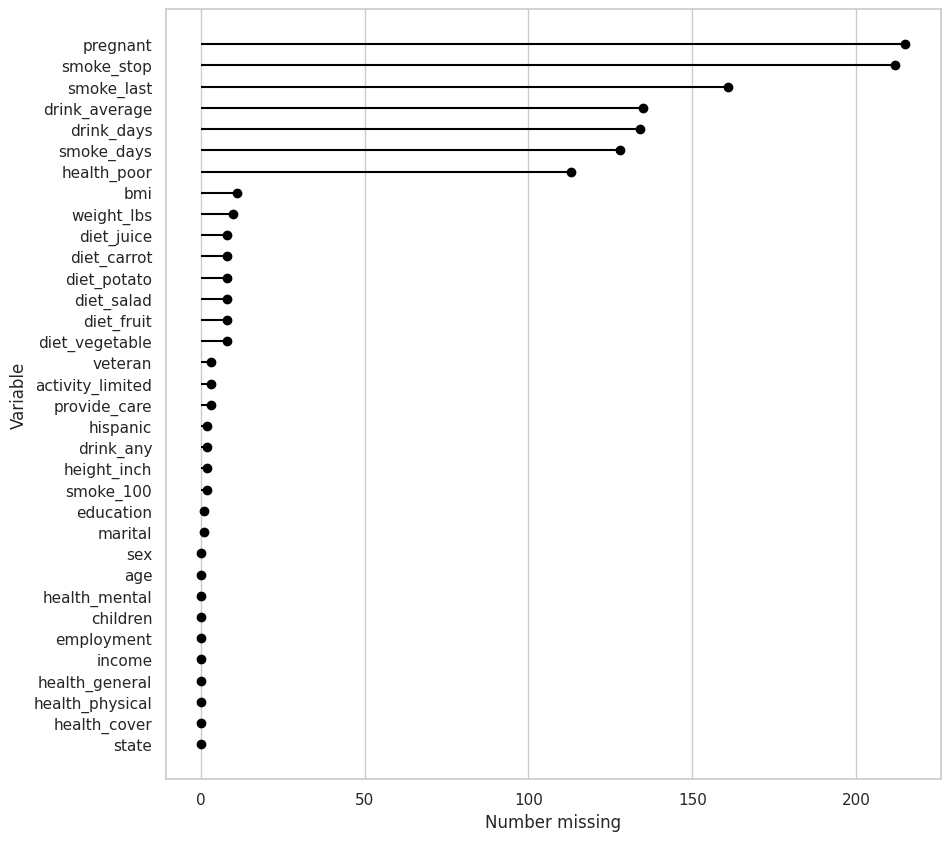

In [33]:
riskfactors_df.missing.missing_variable_plot()

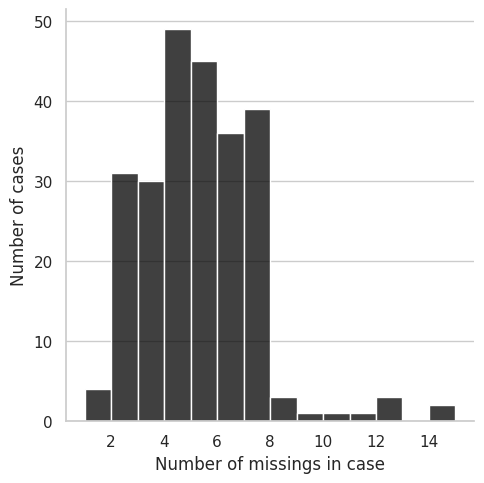

In [34]:
riskfactors_df.missing.missing_case_plot()

###### Tabulación del resumen por caso

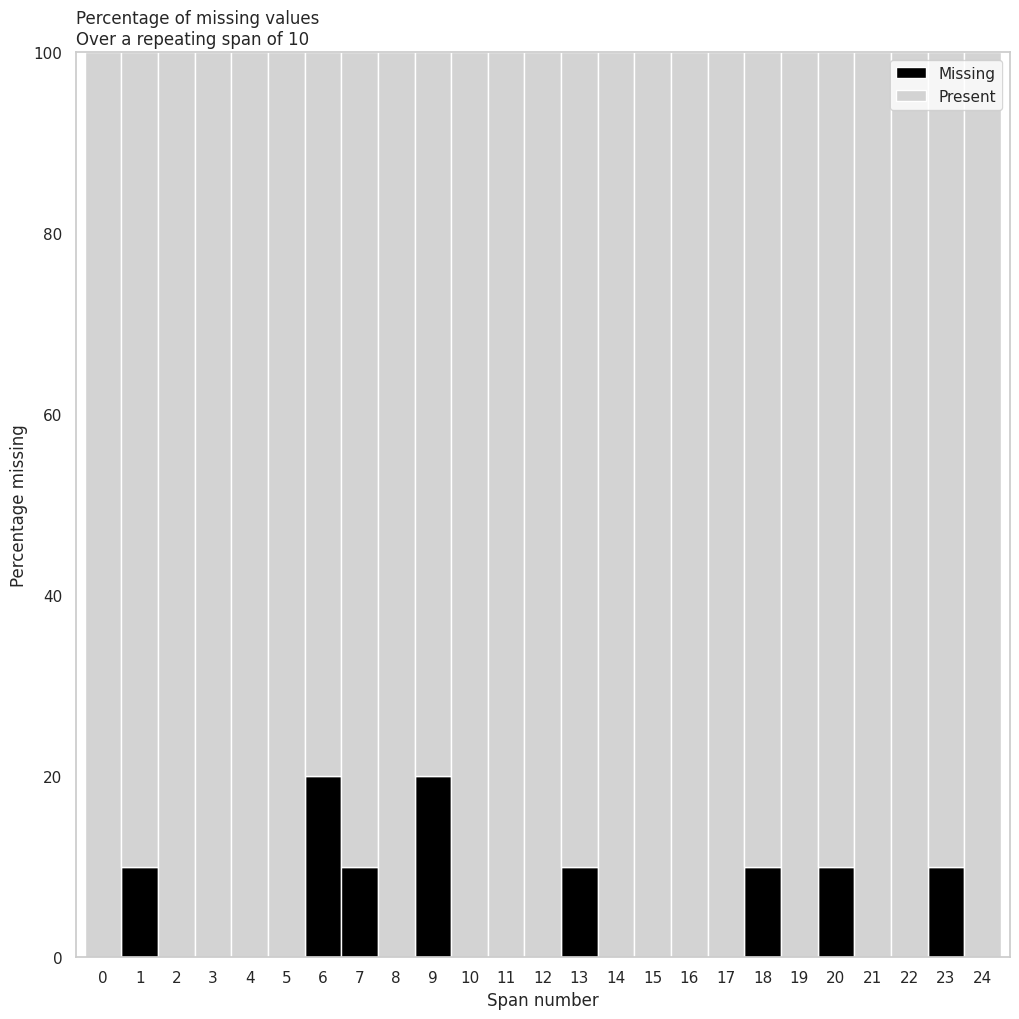

In [35]:
(
    riskfactors_df
    .missing
    .missing_variable_span_plot(
        variable='weight_lbs',
        span_every=10,
        rot= 0
    )
)

### Intervalos de valores faltantes

<AxesSubplot:>

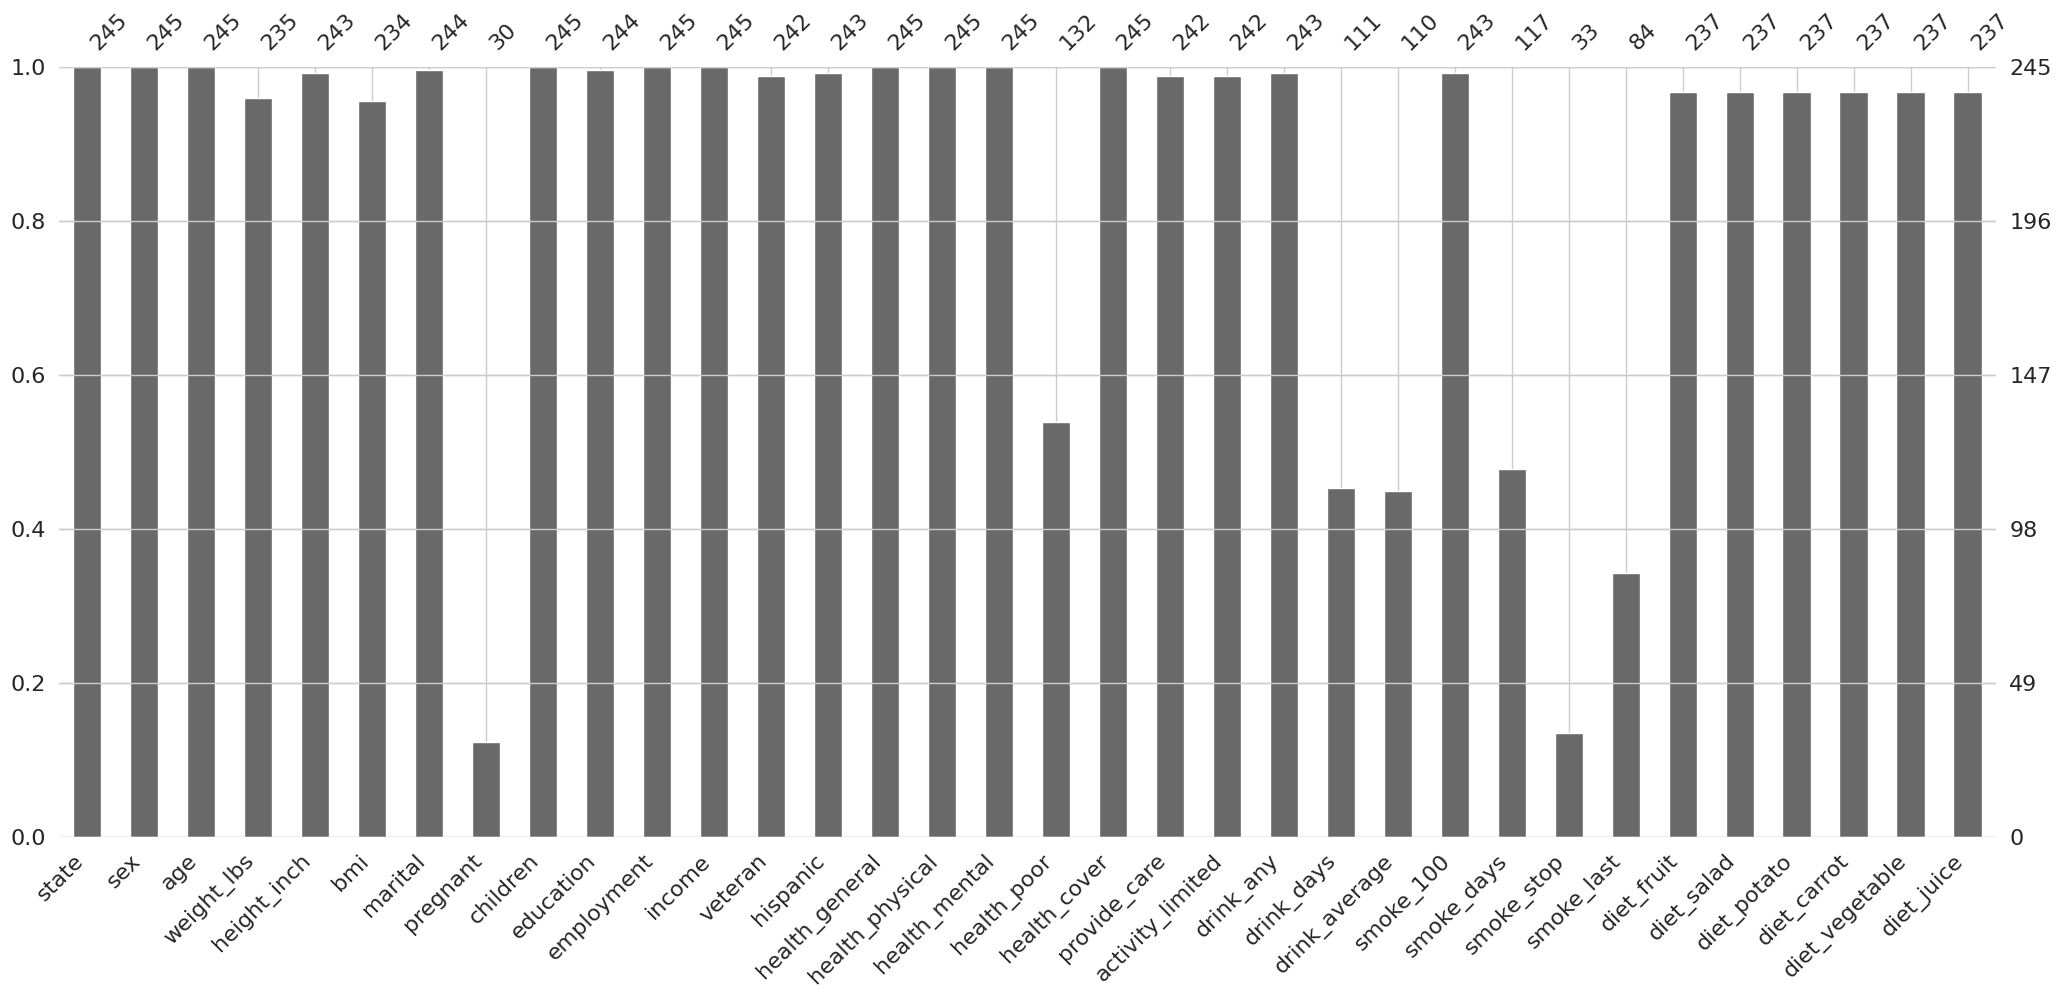

In [36]:
missingno.bar(df = riskfactors_df)

### _Run length_ de valores faltantes

<AxesSubplot:>

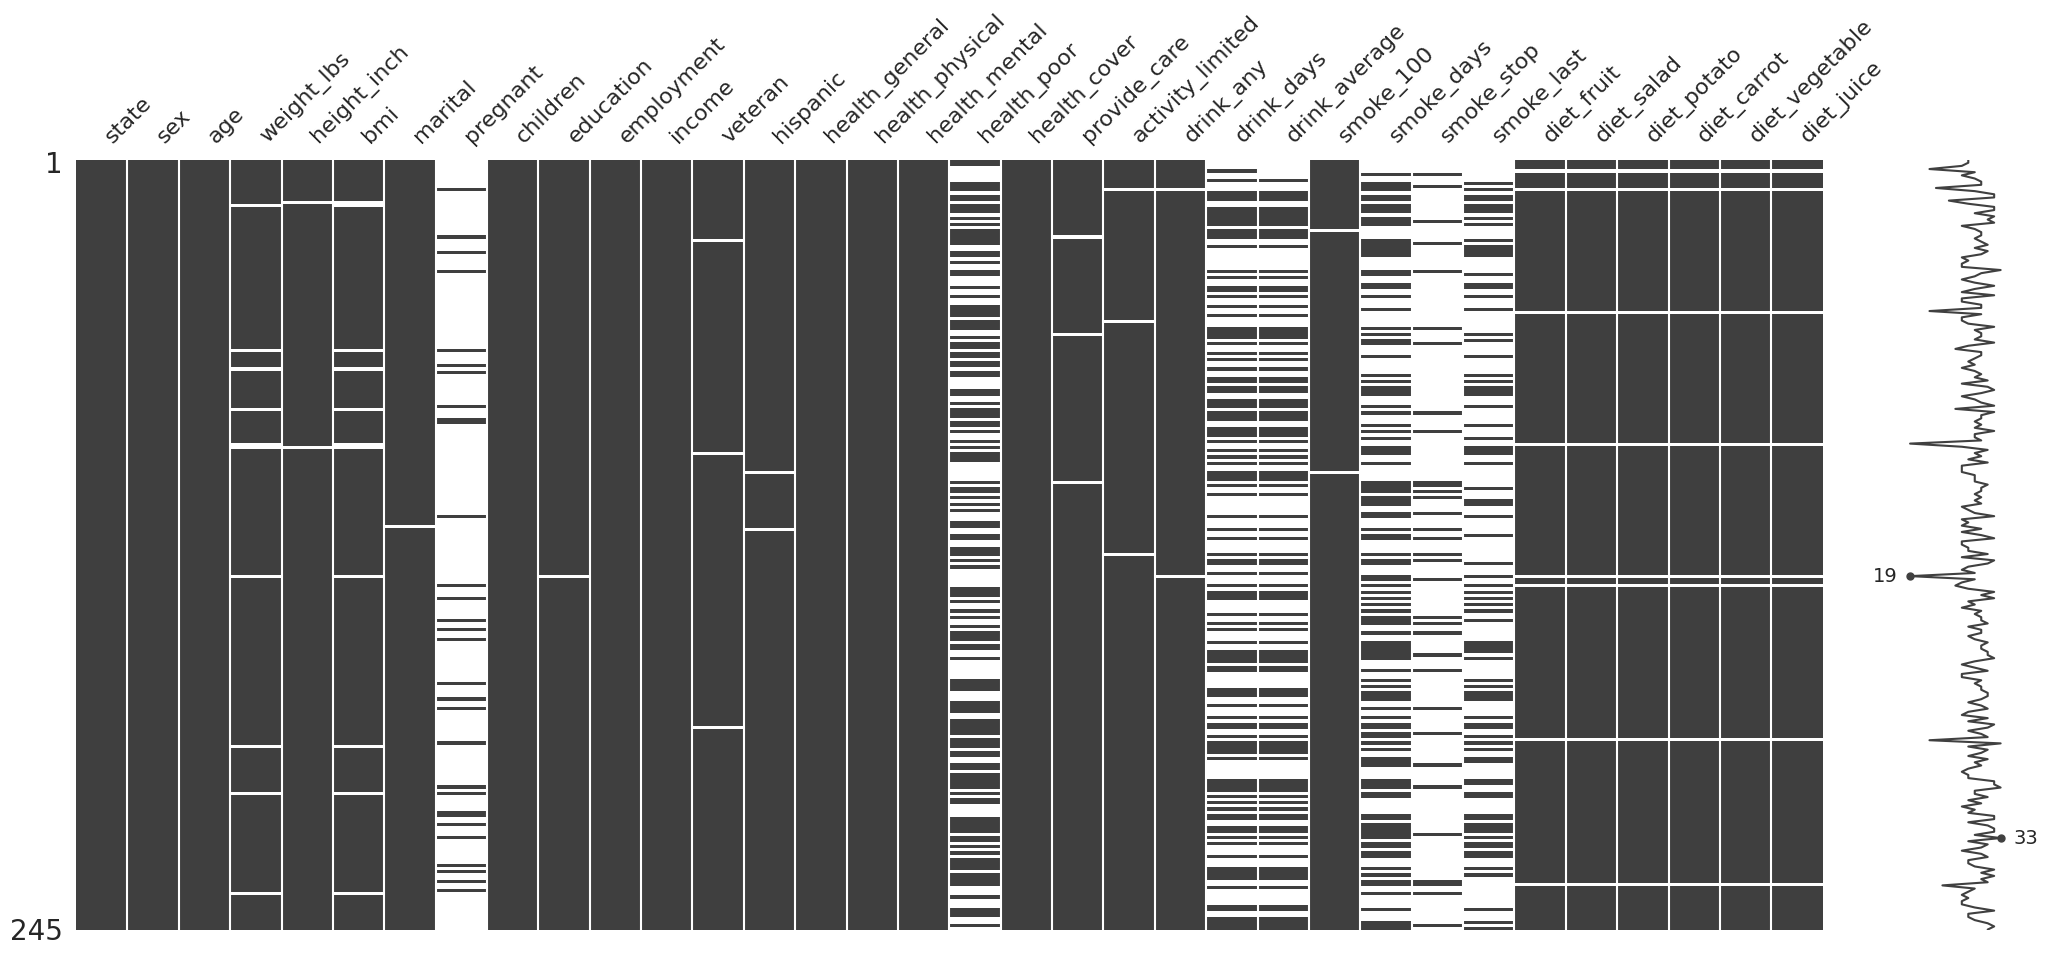

In [37]:
missingno.matrix(df = riskfactors_df)

## Visualización inicial de valores faltantes

### Variable

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

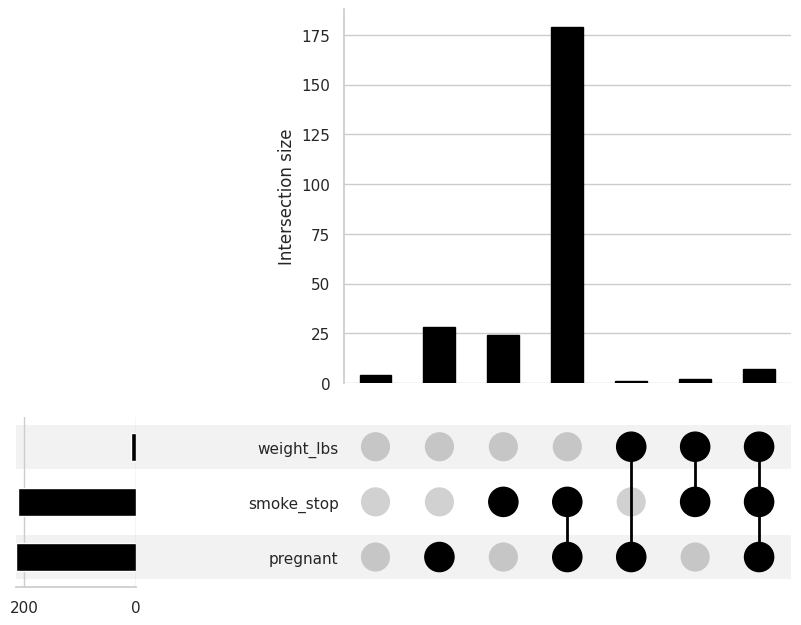

In [38]:
(
    riskfactors_df
    .missing
    .missing_upsetplot(
        variables=['pregnant','weight_lbs','smoke_stop'],
        element_size=60
    )
)

### Casos / Observaciones / Filas

/shared-libs/python3.9/py/lib/python3.9/site-packages/seaborn/matrix.py:306: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/shared-libs/python3.9/py/lib/python3.9/site-packages/seaborn/matrix.py:316: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


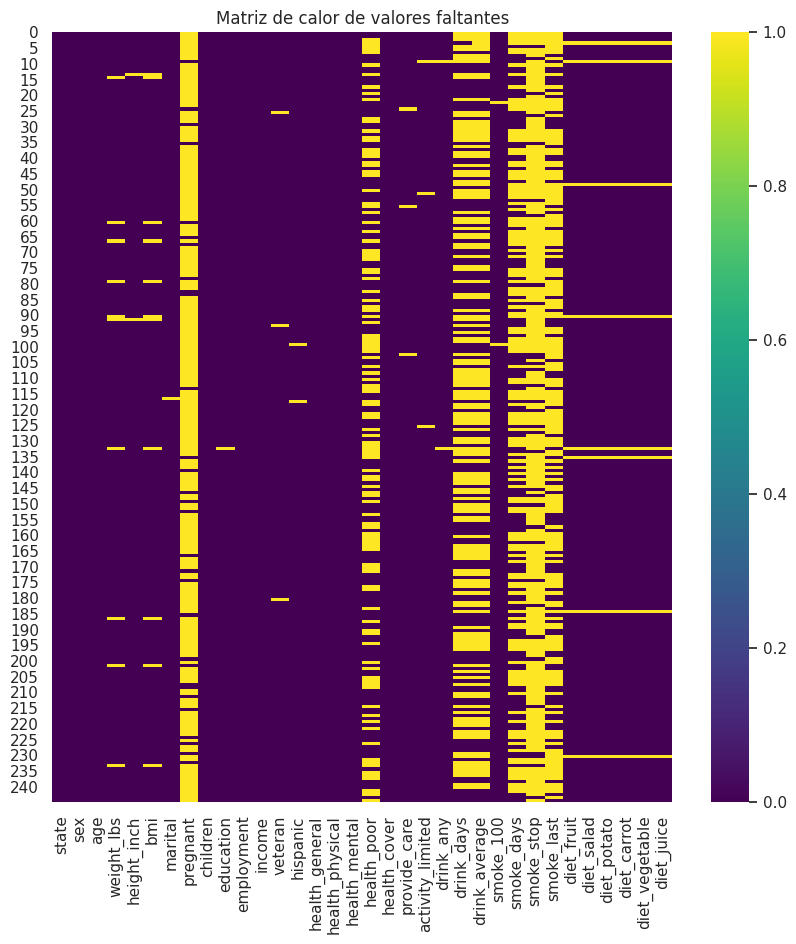

In [39]:
sns.heatmap(riskfactors_df.isnull(), cmap='viridis')
plt.title('Matriz de calor de valores faltantes')
plt.show()

## Codificación de valores faltantes

<div class="alert alert-warning", role="alert">
    <b style="font-size: 1.5em;">🚧 Advertencia</b>
    <p>
    Al igual que cada persona es una nueva puerta a un mundo diferente, los <b>valores faltantes</b> existen en diferentes formas y colores. Al trabajar con valores faltantes será crítico entender sus distintas representaciones. A pesar de que el conjunto de datos de trabajo pareciera que no contiene valores faltantes, deberás ser capaz de ir más allá de lo observado a simple vista para remover el manto tras el cual se esconde lo desconocido.
    </p>
</div>

### Valores comúnmente asociados a valores faltantes

#### Cadenas de texto

In [40]:
common_na_strings = (
    "missing",
    "NA",
    "N A",
    "N/A",
    "#N/A",
    "NA ",
    " NA",
    "N /A",
    "N / A",
    " N / A",
    "N / A ",
    "na",
    "n a",
    "n/a",
    "na ",
    " na",
    "n /a",
    "n / a",
    " a / a",
    "n / a ",
    "NULL",
    "null",
    "",
    "?",
    "*",
    ".",
    "-",
    "--",
    "none",
    "NaN",
    "nan",
    "NAN",
    "nil",
    "NIL",
    "nul",
    "NUL",
    "undefined",
    "UNDEFINED",
    "empty",
    "EMPTY",
    "blank",
    "BLANK",
    "void",
    "VOID",
    "not available",
    "NOT AVAILABLE",
    "no value",
    "NO VALUE",
    "not applicable",
    "NOT APPLICABLE",
    "unknown",
    "UNKNOWN",
)


#### Números

In [41]:
common_na_numbers = (-9, -99, -999, -9999, 9999, 66, 77, 88, -1)

### ¿Cómo encontrar los valores comúnmente asociados a valores faltantes?

In [42]:
missing_data_example_df = pd.DataFrame.from_dict(
    dict(
        x = [1, 3, "NA", -99, -98, -99],
        y = ["A", "N/A", "NA", "E", "F", "G"],
        z = [-100, -99, -98, -101, -1, -1]
    )
)

missing_data_example_df

,x,y,z
0,1,A,-100
1,3,N/A,-99
2,NA,NA,-98
3,-99,E,-101
4,-98,F,-1
5,-99,G,-1


In [43]:
missing_data_example_df.missing.number_missing()

0

#### Revisar tipos de datos

In [44]:
missing_data_example_df.dtypes

x    object
y    object
z     int64
dtype: object

#### Revisar valores únicos de los datos

In [45]:
missing_data_example_df.x.unique()

array([1, 3, 'NA', -99, -98], dtype=object)

In [46]:
(
    missing_data_example_df
    .select_dtypes(object)
    .apply(pd.unique)
)

x     [1, 3, NA, -99, -98]
y    [A, N/A, NA, E, F, G]
dtype: object

### Sustituyendo valores comúnmente asociados a valores faltantes

#### Sustitución desde la lectura de datos

In [47]:
pd.read_csv(
    '/work/data/missing_data_enconding_example.csv',
    na_filter=True,
    na_values=[-99, -1]
)

,x,y,z
0,1.0,A,-100.0
1,3.0,NaN,NaN
2,NaN,NaN,-98.0
3,NaN,E,-101.0
4,-98.0,F,NaN
5,NaN,G,NaN


#### Sustitución global

In [48]:
(
    missing_data_example_df
    .replace(
        to_replace=[-99, 'NA'],
        value=np.nan
    )
)

,x,y,z
0,1.0,A,-100.0
1,3.0,N/A,NaN
2,NaN,NaN,-98.0
3,NaN,E,-101.0
4,-98.0,F,-1.0
5,NaN,G,-1.0


#### Sustitución dirigida

In [49]:
(
    missing_data_example_df
    .replace(
        to_replace={
            'x':{
                -99:np.nan
            }
        }
    )
)

,x,y,z
0,1,A,-100
1,3,N/A,-99
2,NA,NA,-98
3,NaN,E,-101
4,-98,F,-1
5,NaN,G,-1


## Conversión de valores faltantes implícitos a explícitos

<div class="alert alert-warning", role="alert">
    <b style="font-size: 1.5em;">🚧 Advertencia</b>
    <br>
    <br>
    <p>
        <i>
        "<b>Implícito</b> se refiere a todo aquello que se entiende que está incluido
        pero sin ser expresado de forma directa o explícitamente."
        </i>
    </p>
    <p>
    Un <code>valor faltante implícito</code> indica que el valor faltante <b>debería estar incluido</b>
    en el conjunto de datos del análisis, <b>sin que éste lo diga</b> o lo <b>especifique</b>.
    Por lo general, son valores que podemos encontrar al pivotar nuestros datos
    o contabilizar el número de apariciones de combinaciones de las variables de estudio.
    </p>
</div>

In [50]:
implicit_to_explicit_df = pd.DataFrame.from_dict(
    data={
        "name": ["lynn", "lynn", "lynn", "zelda"],
        "time": ["morning", "afternoon", "night", "morning"],
        "value": [350, 310, np.nan, 320]
    }
)

implicit_to_explicit_df

,name,time,value
0,lynn,morning,350.0
1,lynn,afternoon,310.0
2,lynn,night,NaN
3,zelda,morning,320.0


### Estrategias para la identificación de valores faltantes implícitos

#### Pivotar la tabla de datos

In [51]:
(
    implicit_to_explicit_df
    .pivot_wider(
        index="name",
        names_from="time",
        values_from="value"

    )
)

/root/venv/lib/python3.9/site-packages/pandas_flavor/register.py:157: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.pivot` instead.
  return method(self._obj, *args, **kwargs)


,name,afternoon,morning,night
0,lynn,310.0,350.0,NaN
1,zelda,NaN,320.0,NaN


#### Cuantificar ocurrencias de n-tuplas

In [52]:
(
    implicit_to_explicit_df
    .value_counts(
        subset=["name"]
    )
)

name 
lynn     3
zelda    1
dtype: int64

### Exponer filas faltantes implícitas a explícitas

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
       <a href="https://pyjanitor-devs.github.io/pyjanitor/api/functions/#janitor.functions.complete.complete", class="alert-link"><code>janitor.complete()</code></a> está modelada a partir de la función <a href="https://tidyr.tidyverse.org/reference/complete.html", class="alert-link"><code>complete()</code></a> del paquete <a href="https://tidyr.tidyverse.org/index.html", class="alert-link"><code>tidyr</code></a> y es un <i>wrapper</i> alrededor de <a href="https://pyjanitordevs.github.io/pyjanitor/api/functions/#janitor.functions.expand_grid.expand_grid", class="alert-link"><code>janitor.expand_grid()</code></a>, <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html", class="alert-link"><code>pd.merge()</code></a> y <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html", class="alert-link"><code>pd.fillna()</code></a>. En cierto modo, es lo contrario de <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html", class="alert-link"><code>pd.dropna()</code></a>, ya que expone implícitamente las filas que faltan.
    </p>
    <p>
    Son posibles combinaciones de nombres de columnas o una lista/tupla de nombres de columnas, o incluso un  diccionario de nombres de columna y nuevos valores.
    </p>
    <p>
    Las columnas <a href="https://pandas.pydata.org/docs/user_guide/advanced.html"><code>MultiIndex</code></a> no son complatibles.
    </p>
</div>

#### Exponer n-tuplas de valores faltantes

Ejemplo, encontrar los pares faltantes de `name` y `time`.

In [53]:
 (
     implicit_to_explicit_df
     # janitor
     .complete(
         'name',
         'time'
     )
 )

,name,time,value
0,lynn,morning,350.0
1,lynn,afternoon,310.0
2,lynn,night,NaN
3,zelda,morning,320.0
4,zelda,afternoon,NaN
5,zelda,night,NaN


#### Limitar la exposición de n-tuplas de valores faltantes

In [54]:
(
    implicit_to_explicit_df
    .complete(
        {'name' : ['lynn', 'zelda']},
        {'time':['morning','afternoon']},
        sort = True
    )
)

,name,time,value
0,lynn,afternoon,310.0
1,lynn,morning,350.0
2,zelda,afternoon,NaN
3,zelda,morning,320.0
4,lynn,night,NaN


#### Rellenar los valores faltantes

In [55]:
(
    implicit_to_explicit_df
    .complete(
        'name',
        'time',
        fill_value=np.nan
    )
)

,name,time,value
0,lynn,morning,350.0
1,lynn,afternoon,310.0
2,lynn,night,NaN
3,zelda,morning,320.0
4,zelda,afternoon,NaN
5,zelda,night,NaN


#### Limitar el rellenado de valores faltantes implícitos

In [56]:
(
    implicit_to_explicit_df
    .complete(
        'name',
        'time',
        fill_value=0,
        explicit=False
    )
)

,name,time,value
0,lynn,morning,350.0
1,lynn,afternoon,310.0
2,lynn,night,NaN
3,zelda,morning,320.0
4,zelda,afternoon,0.0
5,zelda,night,0.0


## Tipos de valores faltantes

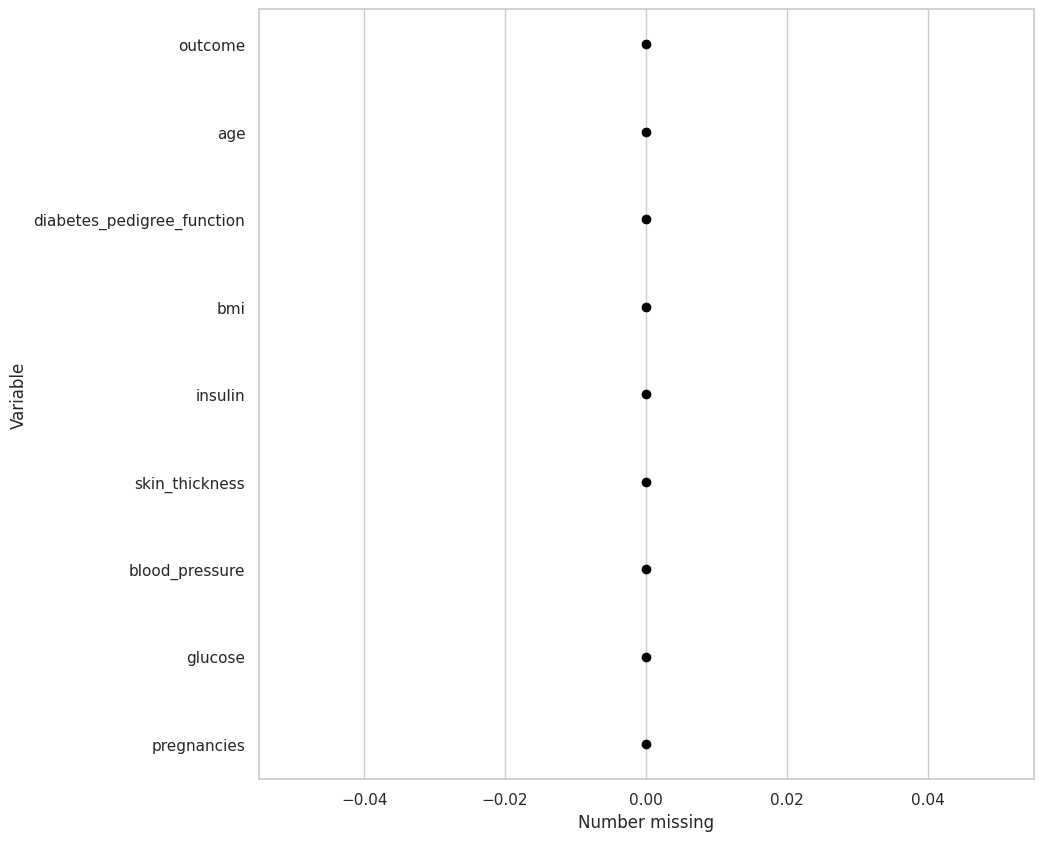

In [57]:
diabetes_df.missing.missing_variable_plot()

### _Missing Completely At Random_ (MCAR)

<AxesSubplot:>

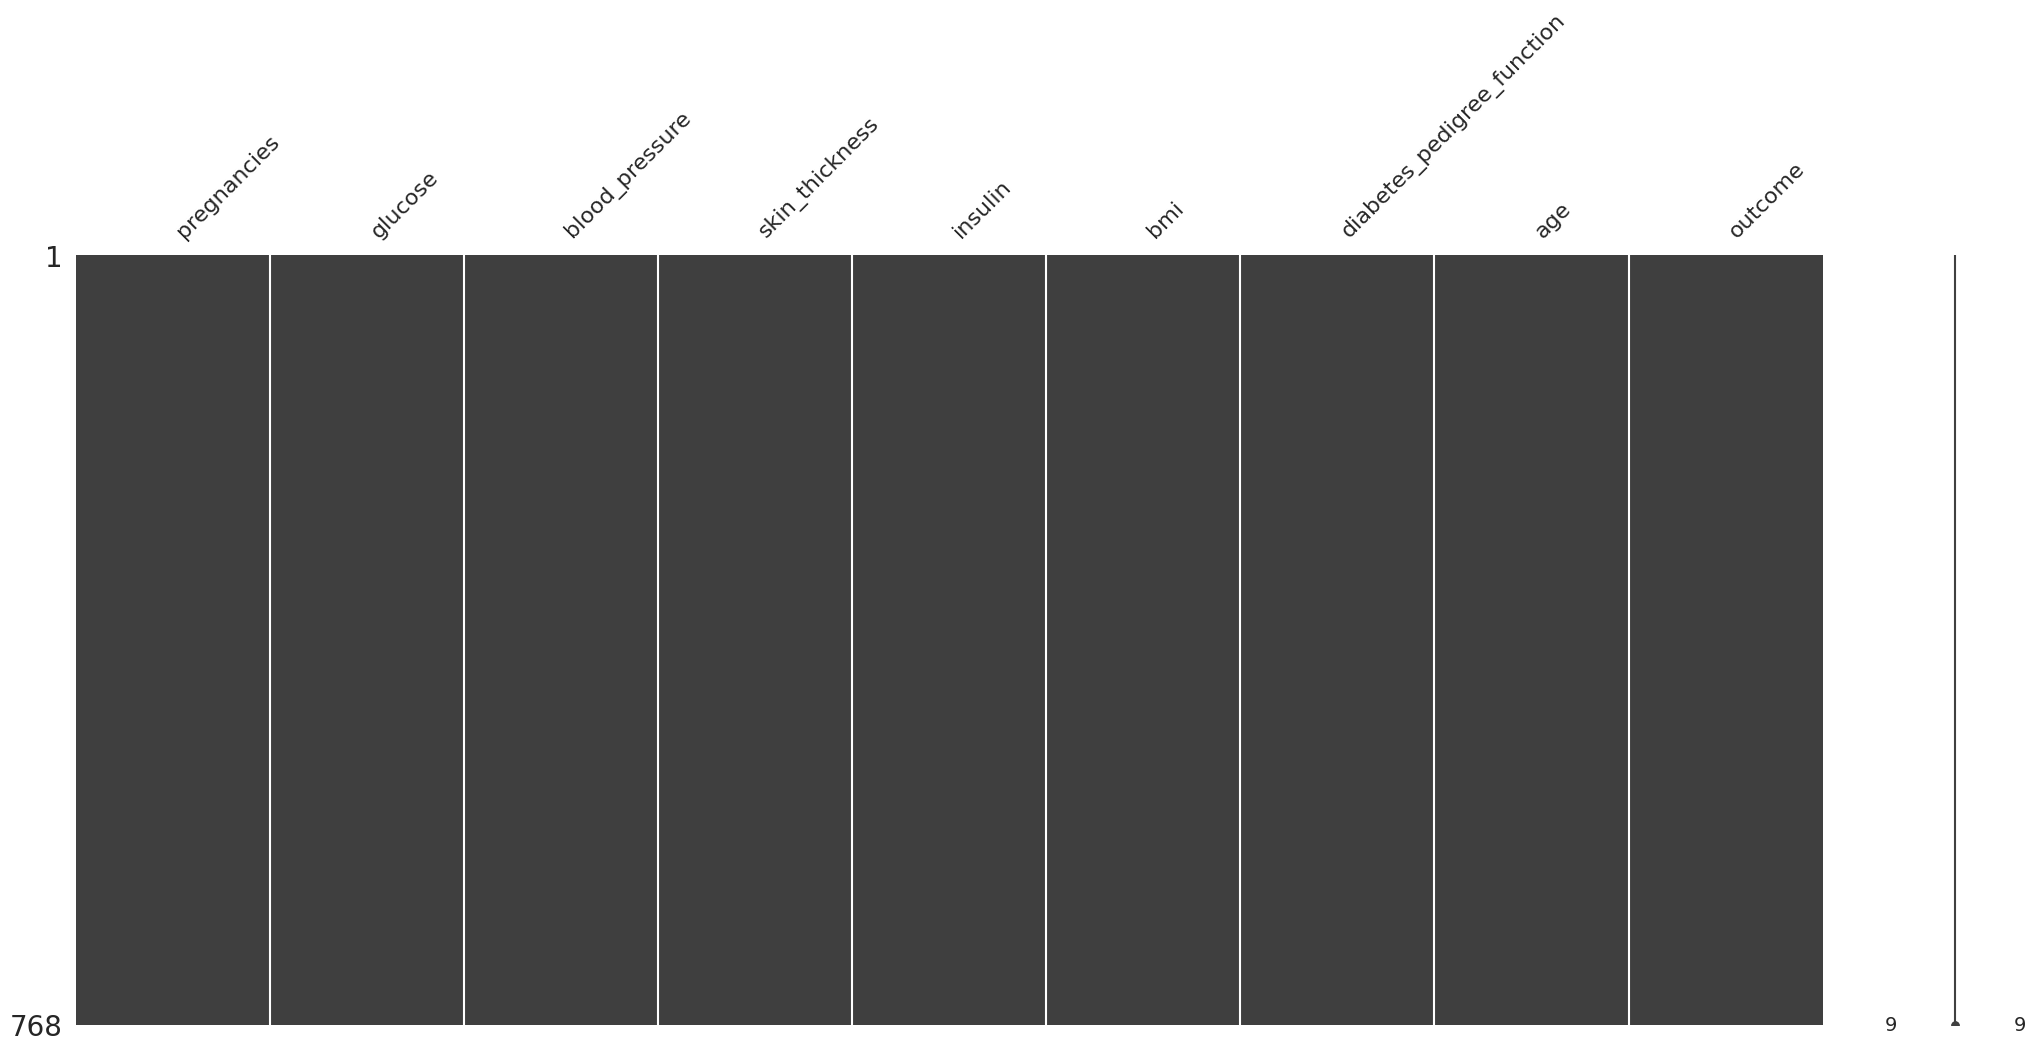

In [58]:
(
    diabetes_df
    .missing.sort_variables_by_missingness()
    .pipe(missingno.matrix)
)

### _Missing At Random_ (MAR)

<AxesSubplot:>

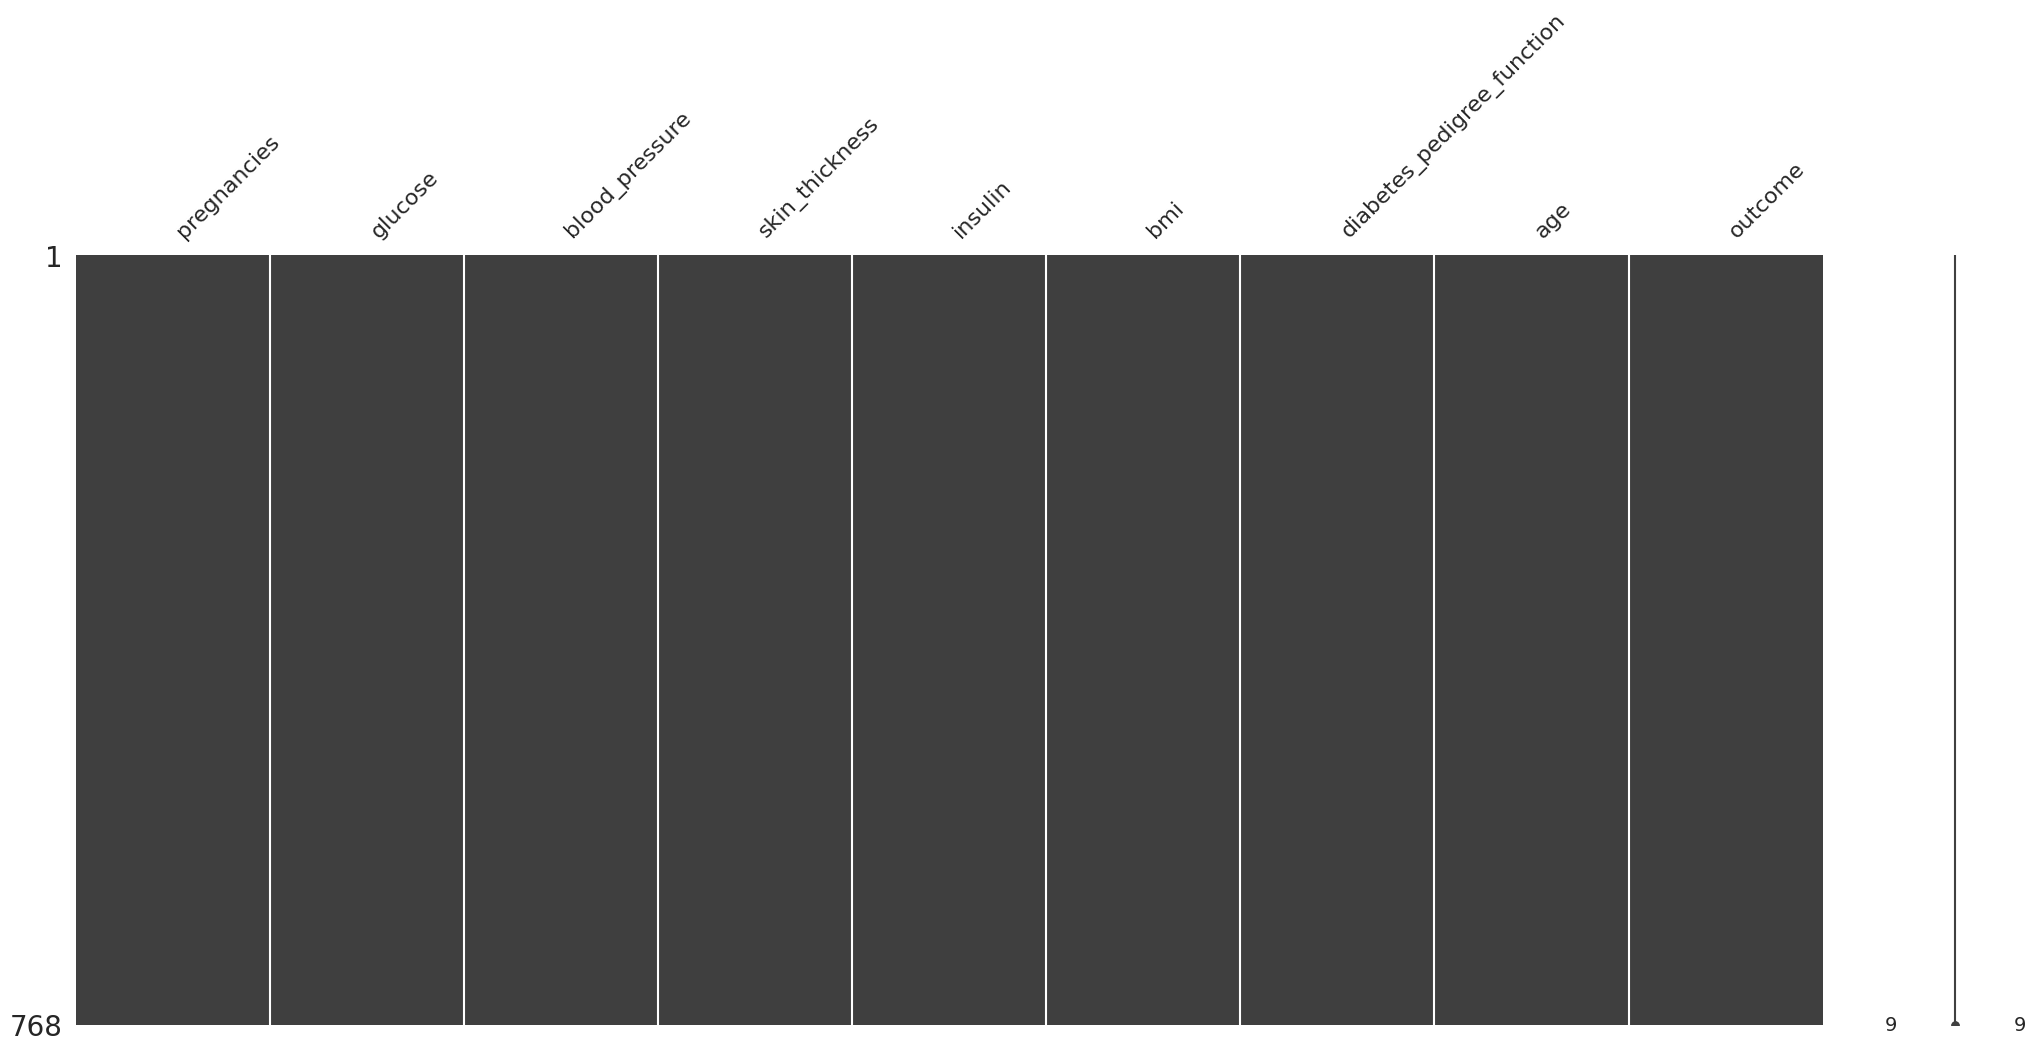

In [59]:
(
    diabetes_df
    .missing.sort_variables_by_missingness()
    .sort_values(by='blood_pressure') # ordena los valores segun una columna
    .pipe(missingno.matrix)
)

### _Missing Not At Random_ (MNAR)

<AxesSubplot:>

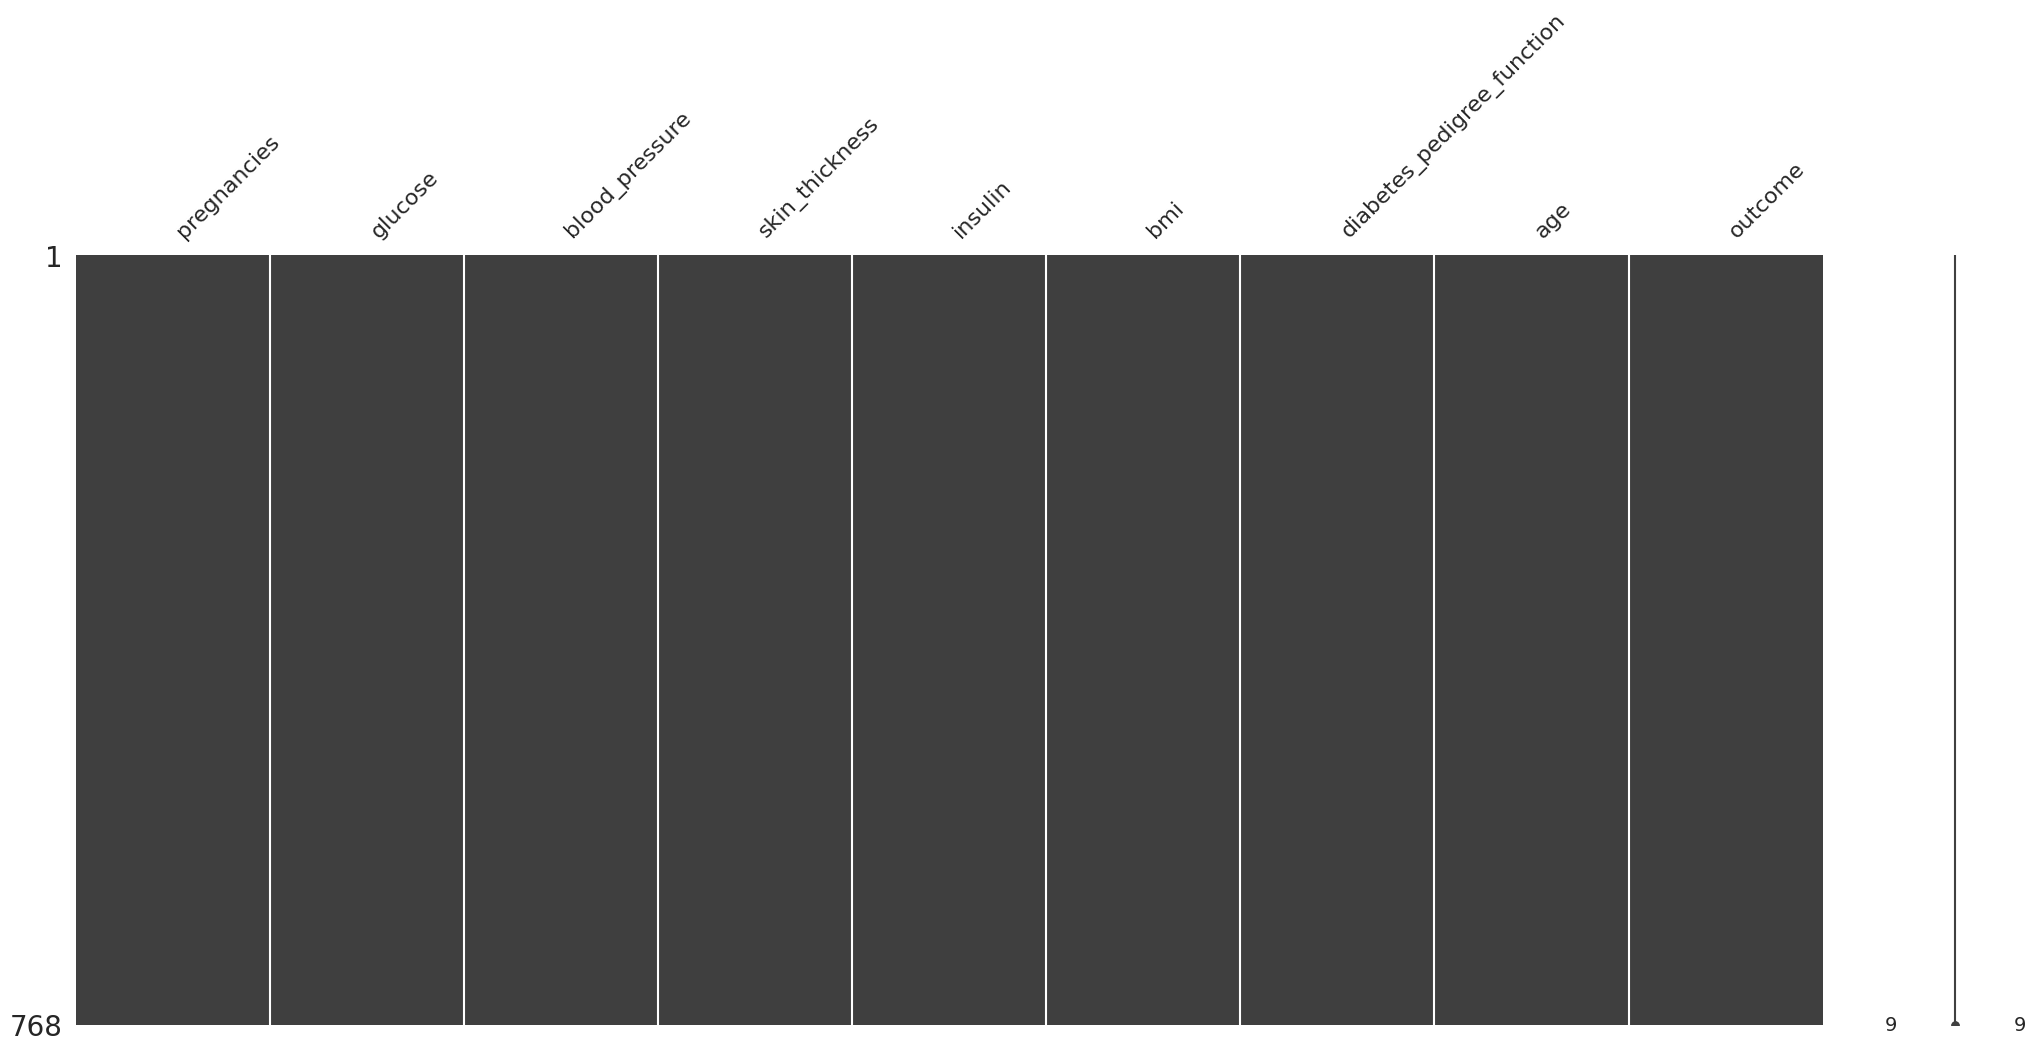

In [60]:
(
    diabetes_df
    .missing.sort_variables_by_missingness()
    .sort_values(by='insulin') # ordena los valores segun una columna
    .pipe(missingno.matrix)
)

## Concepto y aplicación de la matriz de sombras (_i.e._, _shadow matrix_)

 ### Construcción de la matriz de sombras

In [61]:
(
    riskfactors_df
    .isna()
    .replace({
        False: 'Not missing',
        True: 'Missing'
    })
    .add_suffix('_NA')
    .pipe(
        lambda shadow_matrix: pd.concat(
            [riskfactors_df,shadow_matrix],
            axis='columns'
        )
    )
)

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100_NA,smoke_days_NA,smoke_stop_NA,smoke_last_NA,diet_fruit_NA,diet_salad_NA,diet_potato_NA,diet_carrot_NA,diet_vegetable_NA,diet_juice_NA
0,26,Female,49,190,64,32.68,Married,NaN,0,6,...,Not missing,Missing,Missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
1,40,Female,48,170,68,25.90,Divorced,NaN,0,5,...,Not missing,Missing,Missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
2,72,Female,55,163,64,28.04,Married,NaN,0,4,...,Not missing,Missing,Missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
3,42,Male,42,230,74,29.59,Married,NaN,1,6,...,Not missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing
4,32,Female,66,135,62,24.74,Widowed,NaN,0,5,...,Not missing,Not missing,Not missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,10,Female,79,144,63,25.56,Widowed,NaN,0,4,...,Not missing,Missing,Missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
241,46,Male,45,170,74,21.87,Divorced,NaN,2,4,...,Not missing,Missing,Missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
242,15,Male,62,175,71,24.46,Divorced,NaN,0,6,...,Not missing,Not missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing
243,34,Female,62,138,64,23.74,Married,NaN,0,4,...,Not missing,Not missing,Not missing,Missing,Not missing,Not missing,Not missing,Not missing,Not missing,Not missing


### Utilizar función de utilería `bind_shadow_matrix()`

In [62]:
(
    riskfactors_df
    .missing
    .bind_shadow_matrix()
)

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100_NA,smoke_days_NA,smoke_stop_NA,smoke_last_NA,diet_fruit_NA,diet_salad_NA,diet_potato_NA,diet_carrot_NA,diet_vegetable_NA,diet_juice_NA
0,26,Female,49,190,64,32.68,Married,NaN,0,6,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
1,40,Female,48,170,68,25.90,Divorced,NaN,0,5,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
2,72,Female,55,163,64,28.04,Married,NaN,0,4,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
3,42,Male,42,230,74,29.59,Married,NaN,1,6,...,Not Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing
4,32,Female,66,135,62,24.74,Widowed,NaN,0,5,...,Not Missing,Not Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,10,Female,79,144,63,25.56,Widowed,NaN,0,4,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
241,46,Male,45,170,74,21.87,Divorced,NaN,2,4,...,Not Missing,Missing,Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
242,15,Male,62,175,71,24.46,Divorced,NaN,0,6,...,Not Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing
243,34,Female,62,138,64,23.74,Married,NaN,0,4,...,Not Missing,Not Missing,Not Missing,Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing,Not Missing


### Explorar estadísticos utilizando las nuevas columnas de la matriz de sombras

Missing or not Pregnancy by age


<AxesSubplot:xlabel='weight_lbs_NA', ylabel='age'>

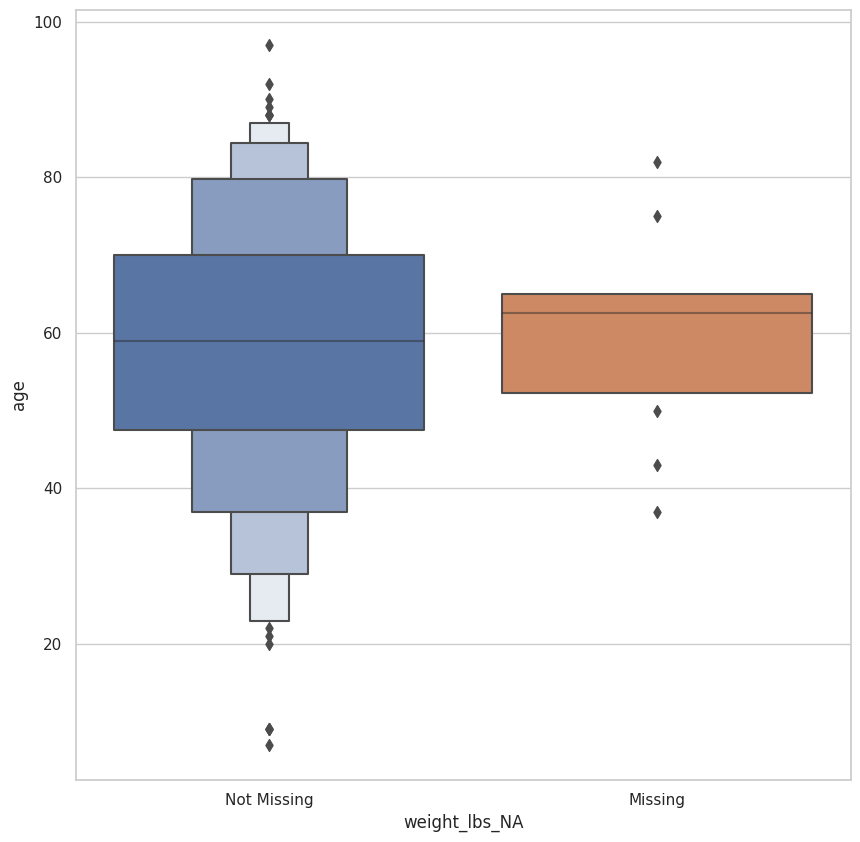

In [63]:
print('Missing or not Pregnancy by age')
(
    riskfactors_df
    .missing.bind_shadow_matrix(only_missing=True)
    .pipe(
        lambda df: (
            sns.boxenplot(
                data=df,
                x='weight_lbs_NA',
                y='age'
            )
        )
    )
)

## Visualización de valores faltantes en una variable

<AxesSubplot:xlabel='weight_lbs_NA', ylabel='age'>

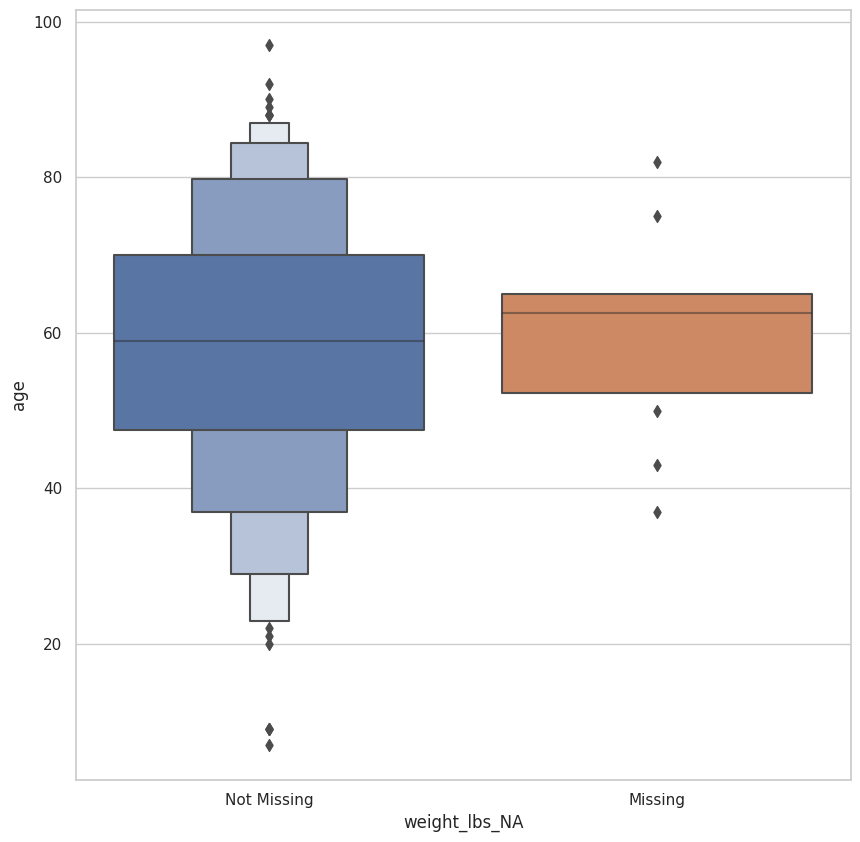

In [64]:
(
    riskfactors_df
    .missing.bind_shadow_matrix(only_missing=True)
    .pipe(
        lambda df: (
            sns.boxenplot(
                data=df,
                x = 'weight_lbs_NA', #variables con datos faltantes
                y = 'age'  #variable de comparacion
            )
        )
    )
)

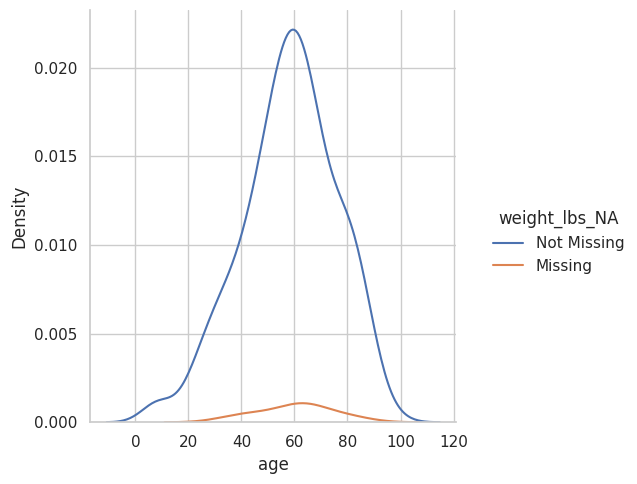

In [65]:
(
    riskfactors_df
    .missing.bind_shadow_matrix(only_missing=True)
    .pipe(
        lambda df: (
            sns.displot(
                data=df,
                x = 'age', #variable de distribucion
                hue = 'weight_lbs_NA',  #variable de comparacion
                kind= 'kde' #distribucion de densidad
            )
        )
    )
)

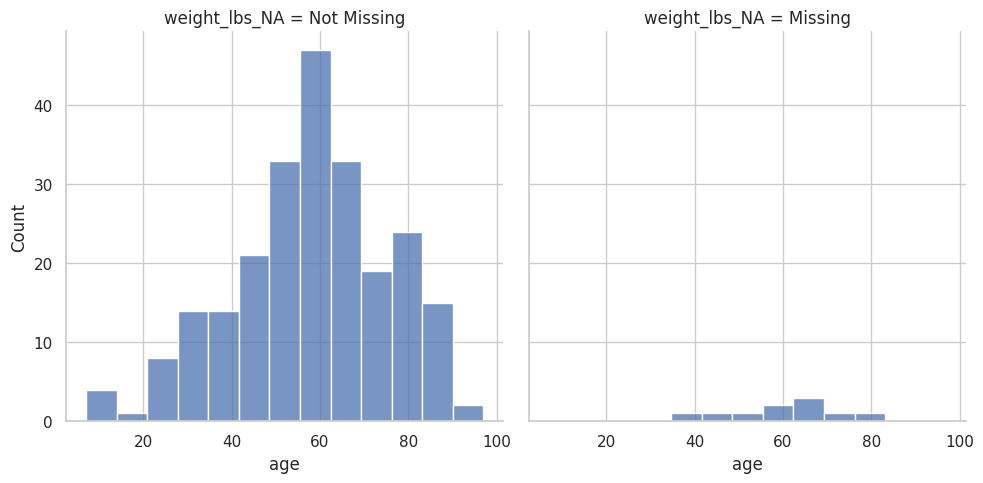

In [66]:
(
    riskfactors_df
    .missing.bind_shadow_matrix(only_missing=True)
    .pipe(
        lambda df: (
            sns.displot(
                data=df,
                x = 'age', #variable de distribucion
                col = 'weight_lbs_NA',  #variable de comparacion
                
            )
        )
    )
)
    

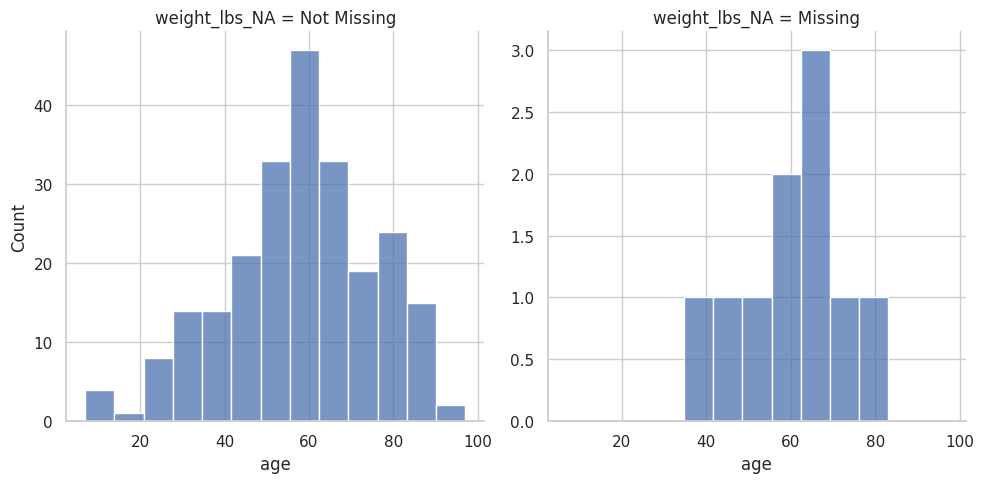

In [67]:
(
    riskfactors_df
    .missing.bind_shadow_matrix(only_missing=True)
    .pipe(
        lambda df: (
            sns.displot(
                data=df,
                x = 'age', #variable de distribucion
                col = 'weight_lbs_NA',  #variable de comparacion
                facet_kws={
                    'sharey': False
                }
                
            )
        )
    )
)

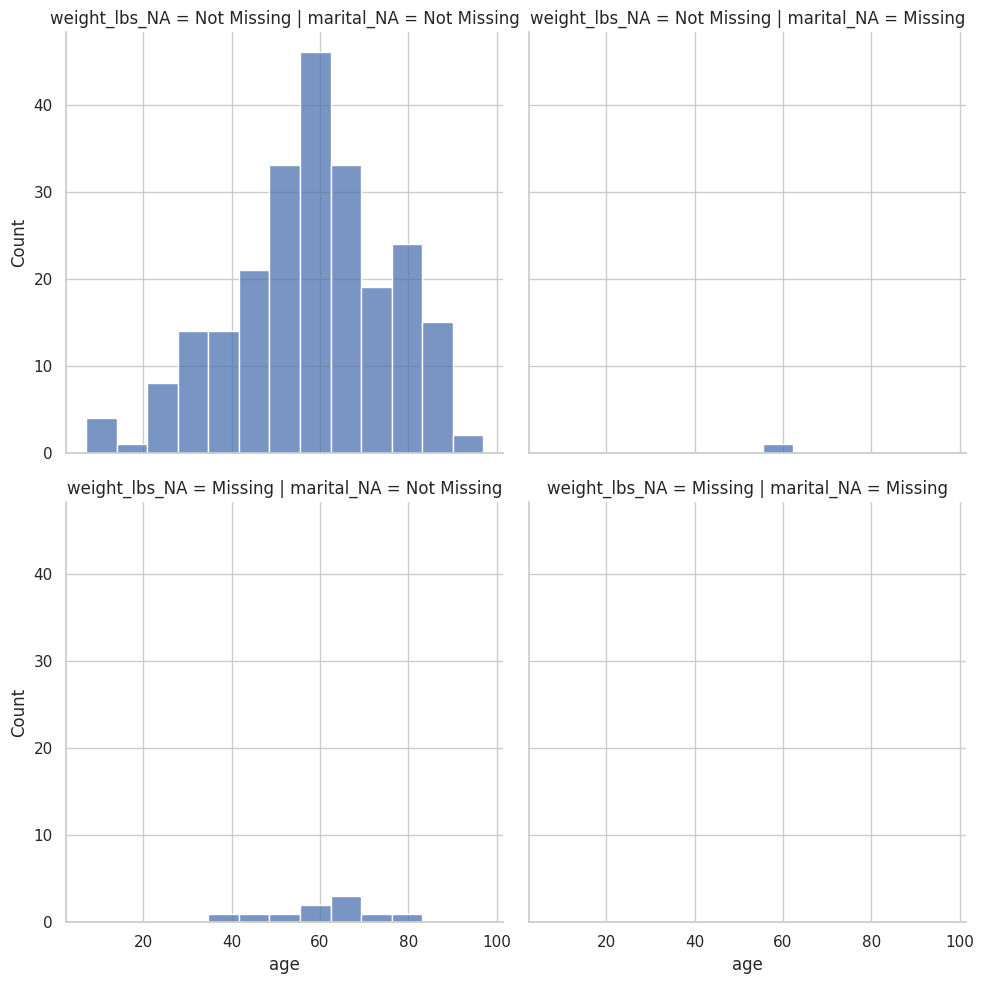

In [68]:
(
    riskfactors_df
    .missing.bind_shadow_matrix(only_missing=True)
    .pipe(
        lambda df: (
            sns.displot(
                data=df,
                x = 'age', #variable de distribucion
                col ='marital_NA',
                row ='weight_lbs_NA'
            )
        )
    )
)

## Visualización de valores faltantes en dos variables

In [71]:
import numpy as np
import pandas as pd

def column_fill_with_dummies(
    column: pd.Series,
    proportion_below: float = 0.10,
    jitter: float = 0.075,
    seed: int = 42
) -> pd.Series:
    column = column.copy(deep=True)

    # Extract values metadata
    missing_mask = column.isna()
    number_missing_values = missing_mask.sum()
    column_range = column.max() - column.min()

    # Shift data
    column_shift = column.min() - column.min() * proportion_below  # Corregido aquí

    # Create the "jitter" (noise) to be added around the points
    np.random.seed(seed)
    column_jitter = (np.random.rand(number_missing_values) - 0.5) * column_range * jitter

    # Save new dummy data
    column[missing_mask] = column_shift + column_jitter

    return column


## Correlación de nulidad

<AxesSubplot:xlabel='weight_lbs', ylabel='height_inch'>

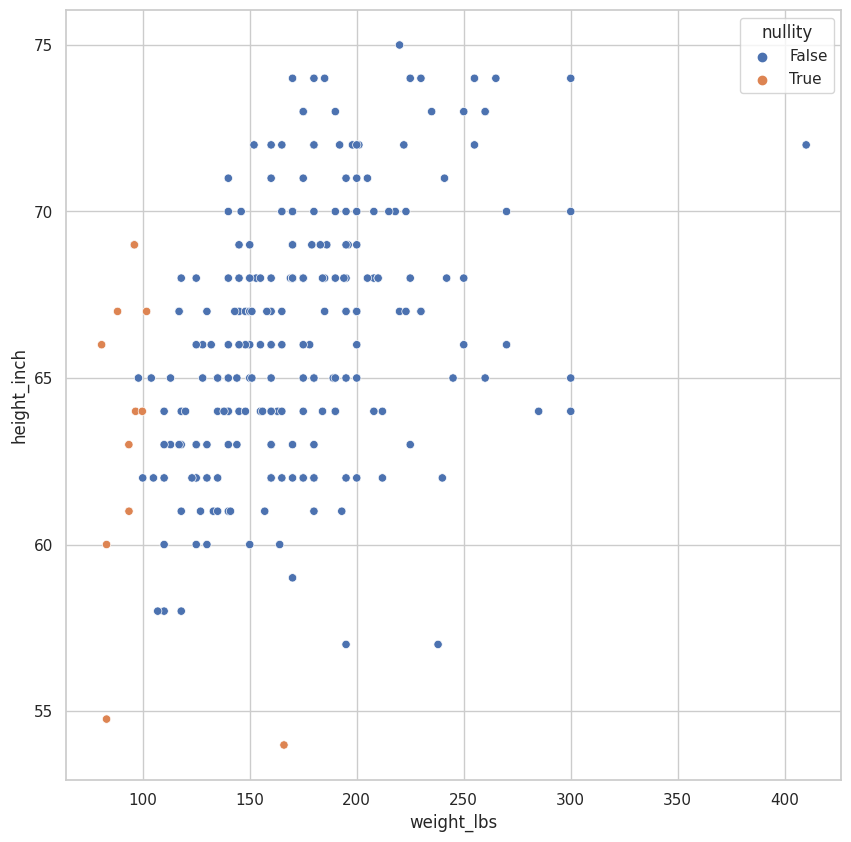

In [77]:
(
    riskfactors_df
    .select_dtypes(
        exclude='category'

    )
    .pipe(
        lambda df: df[df.columns[df.isna().any()]]
    )
    .missing.bind_shadow_matrix(true_string = True, false_string = False)
    .apply(
        lambda column: column if "_NA" in column.name else column_fill_with_dummies(column, proportion_below=0.05, jitter = 0.075)
    )
    .assign(
        nullity = lambda df: df.weight_lbs_NA | df.height_inch_NA
    )
    .pipe(
        lambda df: ( 
            sns.scatterplot(
                data= df,
                x= 'weight_lbs',
                y='height_inch',
                hue='nullity'

            )
        )
    )
)

/shared-libs/python3.9/py/lib/python3.9/site-packages/seaborn/matrix.py:306: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  mesh = ax.pcolormesh(self.plot_data, cmap=self.cmap, **kws)
/shared-libs/python3.9/py/lib/python3.9/site-packages/seaborn/matrix.py:316: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


<AxesSubplot:>

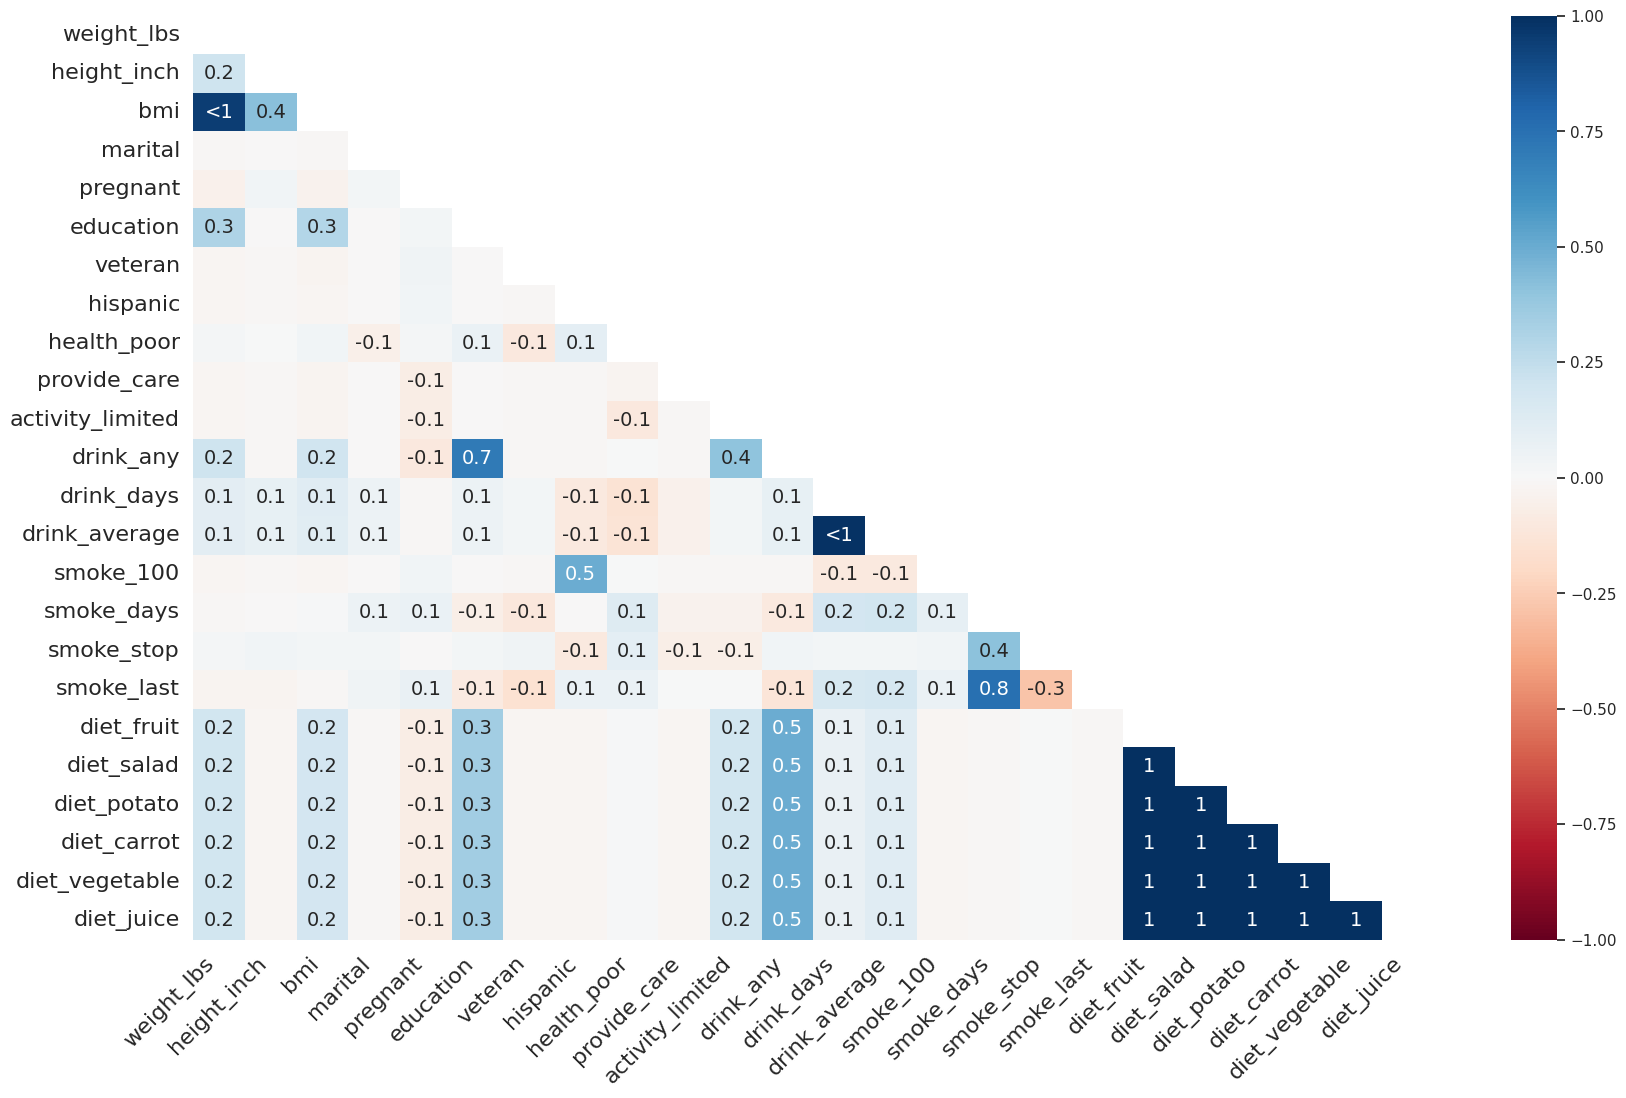

In [78]:
missingno.heatmap(
    df=riskfactors_df
)

<AxesSubplot:>

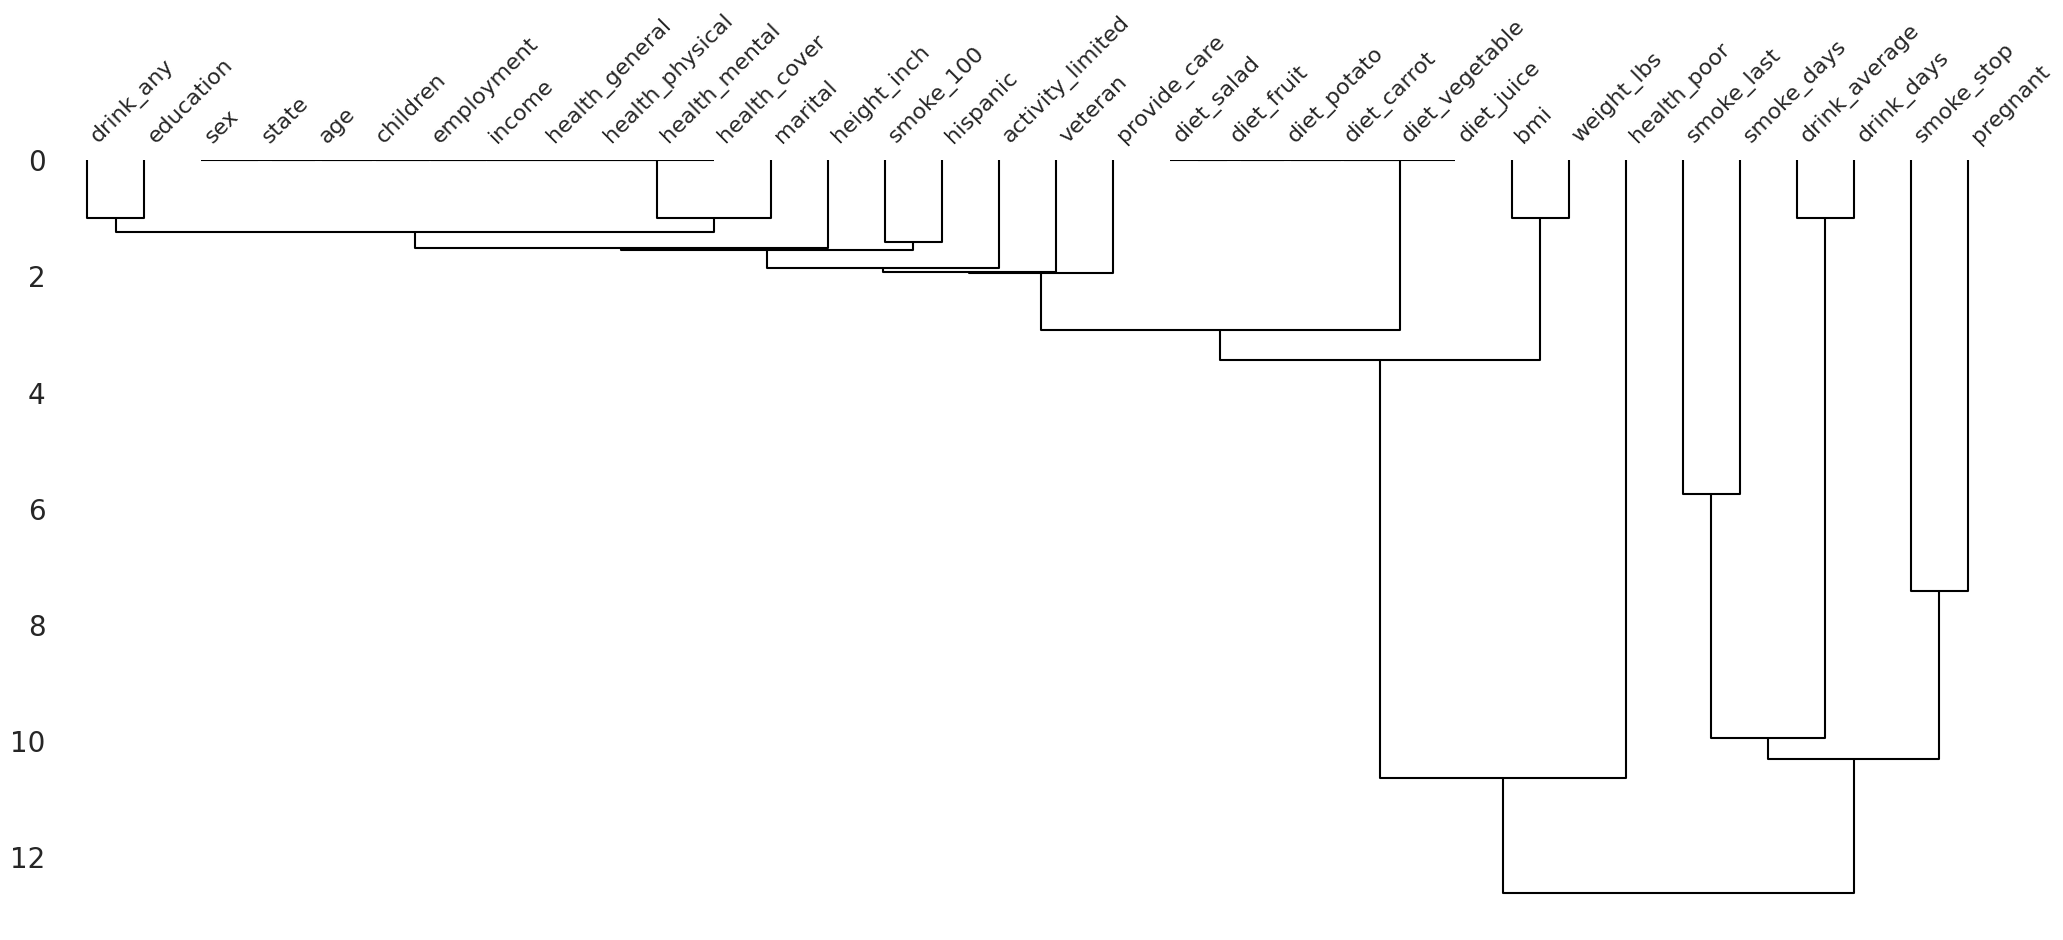

In [79]:
missingno.dendrogram(
    df=riskfactors_df
)

## Eliminación de valores faltantes

<div class="alert alert-warning", role="alert">
    <b style="font-size: 1.5em;">🚧 Advertencia</b>
    <p>
    La eliminación de valores faltantes <b>asume</b> que los valores faltantes están perdidos
    completamente al azar (<code>MCAR</code>). En cualquier otro caso, realizar una
    eliminación de valores faltantes podrá ocasionar <b>sesgos</b> en los
    análisis y modelos subsecuentes.
    </p>
</div>

Primero observa el número total de observaciones y variables que tiene tu conjunto de datos.

In [80]:
riskfactors_df.shape

(245, 34)

### _Pairwise deletion_ (eliminación por pares)

In [81]:
(
    riskfactors_df
    .weight_lbs
    .mean()
)

174.26808510638298

In [82]:
riskfactors_df.weight_lbs.size, riskfactors_df.weight_lbs.count()

(245, 235)

In [83]:
(
    riskfactors_df
    .dropna(
        subset=['weight_lbs'], # indica la variable donde buscar los valores faltantes
        how='any' # any indica en cualquier registro que aparezca un valor faltante
    )
)

,state,sex,age,weight_lbs,height_inch,bmi,marital,pregnant,children,education,...,smoke_100,smoke_days,smoke_stop,smoke_last,diet_fruit,diet_salad,diet_potato,diet_carrot,diet_vegetable,diet_juice
0,26,Female,49,190,64,32.68,Married,NaN,0,6,...,No,NaN,NaN,NaN,1095,261,104,156,521,12
1,40,Female,48,170,68,25.90,Divorced,NaN,0,5,...,No,NaN,NaN,NaN,52,209,52,0,52,0
2,72,Female,55,163,64,28.04,Married,NaN,0,4,...,No,NaN,NaN,NaN,36,156,52,24,24,24
3,42,Male,42,230,74,29.59,Married,NaN,1,6,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,32,Female,66,135,62,24.74,Widowed,NaN,0,5,...,Yes,Everyday,Yes,NaN,-7,261,209,261,365,104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,10,Female,79,144,63,25.56,Widowed,NaN,0,4,...,No,NaN,NaN,NaN,-7,-7,-7,-7,-7,-7
241,46,Male,45,170,74,21.87,Divorced,NaN,2,4,...,No,NaN,NaN,NaN,52,52,52,24,52,24
242,15,Male,62,175,71,24.46,Divorced,NaN,0,6,...,Yes,Not@All,NaN,7,365,156,104,52,730,365
243,34,Female,62,138,64,23.74,Married,NaN,0,4,...,Yes,Everyday,No,NaN,730,0,24,156,104,0


In [84]:
riskfactors_df.weight_lbs.mean(skipna=False)

nan

### _Listwise Deletion or Complete Case_ (Eliminación por lista o caso completo)

#### Con base en 1 columna

In [85]:
(
    riskfactors_df
    .dropna(
        subset=['weight_lbs'],
        how='any'
    )
    .shape
)

(235, 34)

#### Con base en 2 o más columnas

In [86]:
(
    riskfactors_df
    .dropna(
        subset=['weight_lbs','height_inch'],
        how='any'
    )
    .shape
)

(234, 34)

In [87]:
(
    riskfactors_df
    .dropna(
        subset=['weight_lbs','height_inch'],
        how='all'
    )
    .shape
)

(244, 34)

### Representación gráfica tras la eliminación de los valores faltantes

<AxesSubplot:>

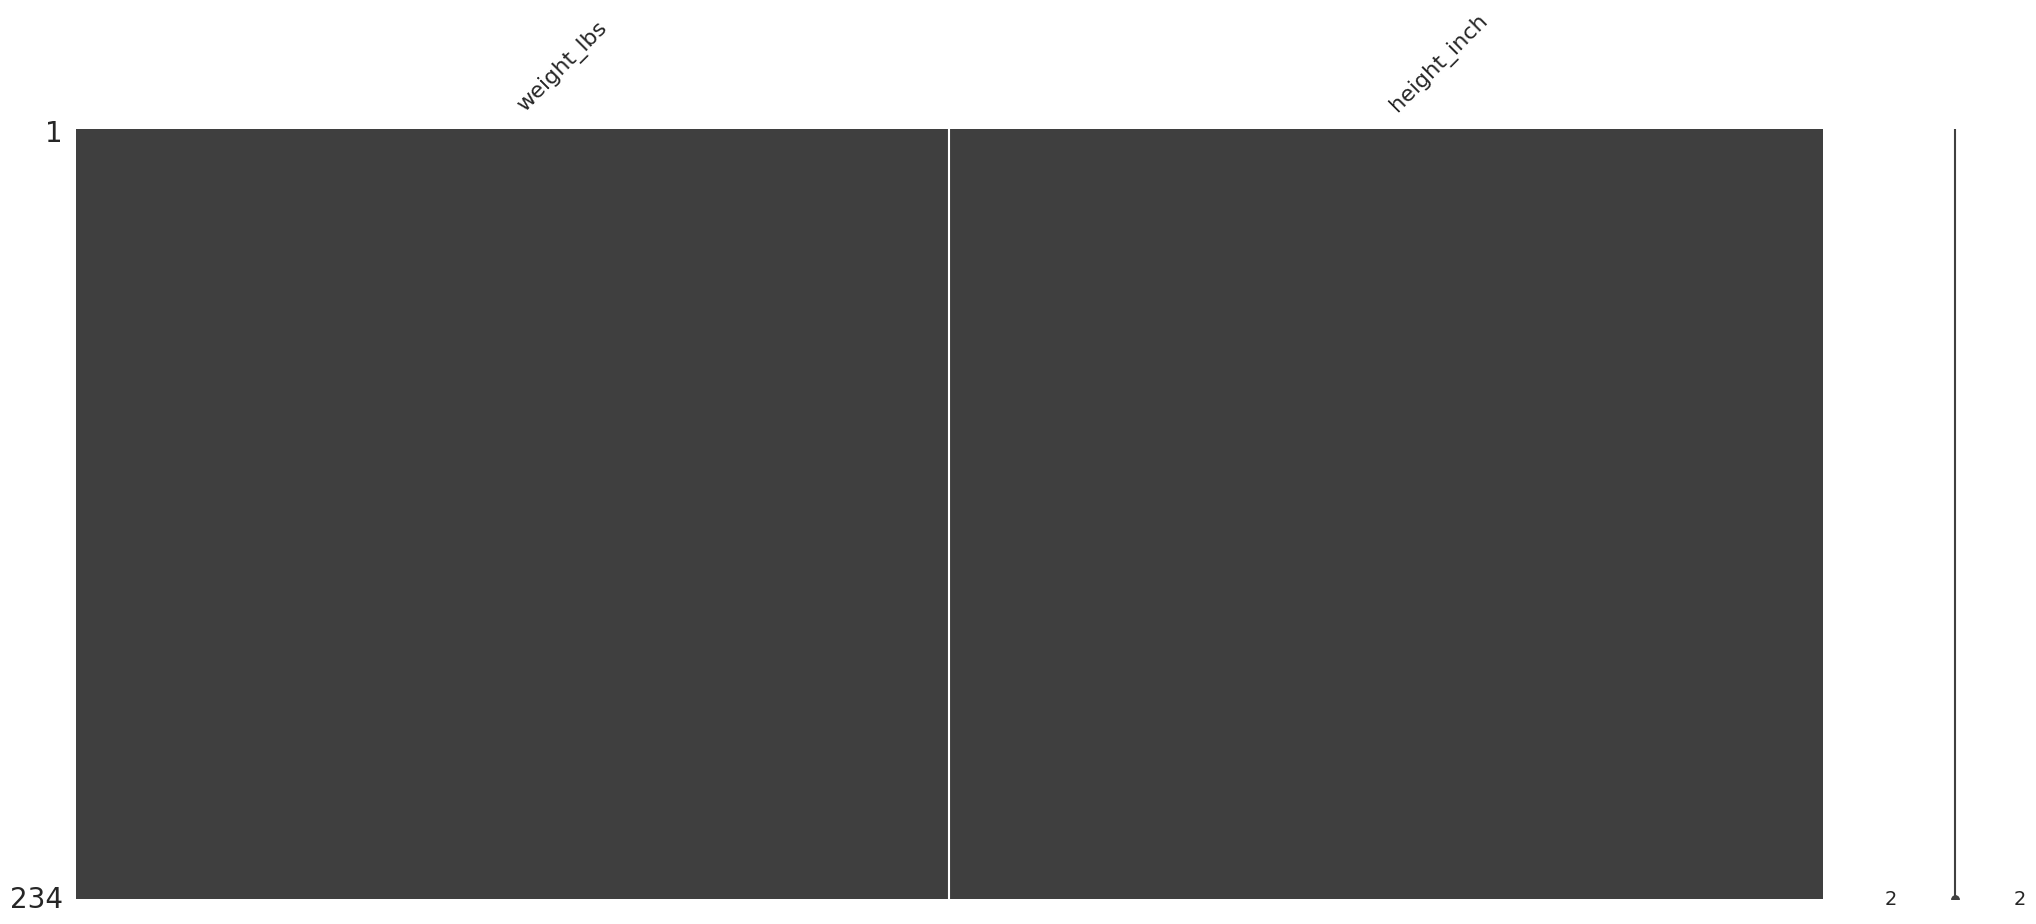

In [88]:
(
    riskfactors_df
    .dropna(
        subset=['weight_lbs','height_inch'],
        how='any'
    )
    .select_columns(['weight_lbs','height_inch'])
    .pipe(missingno.matrix)
)

<AxesSubplot:>

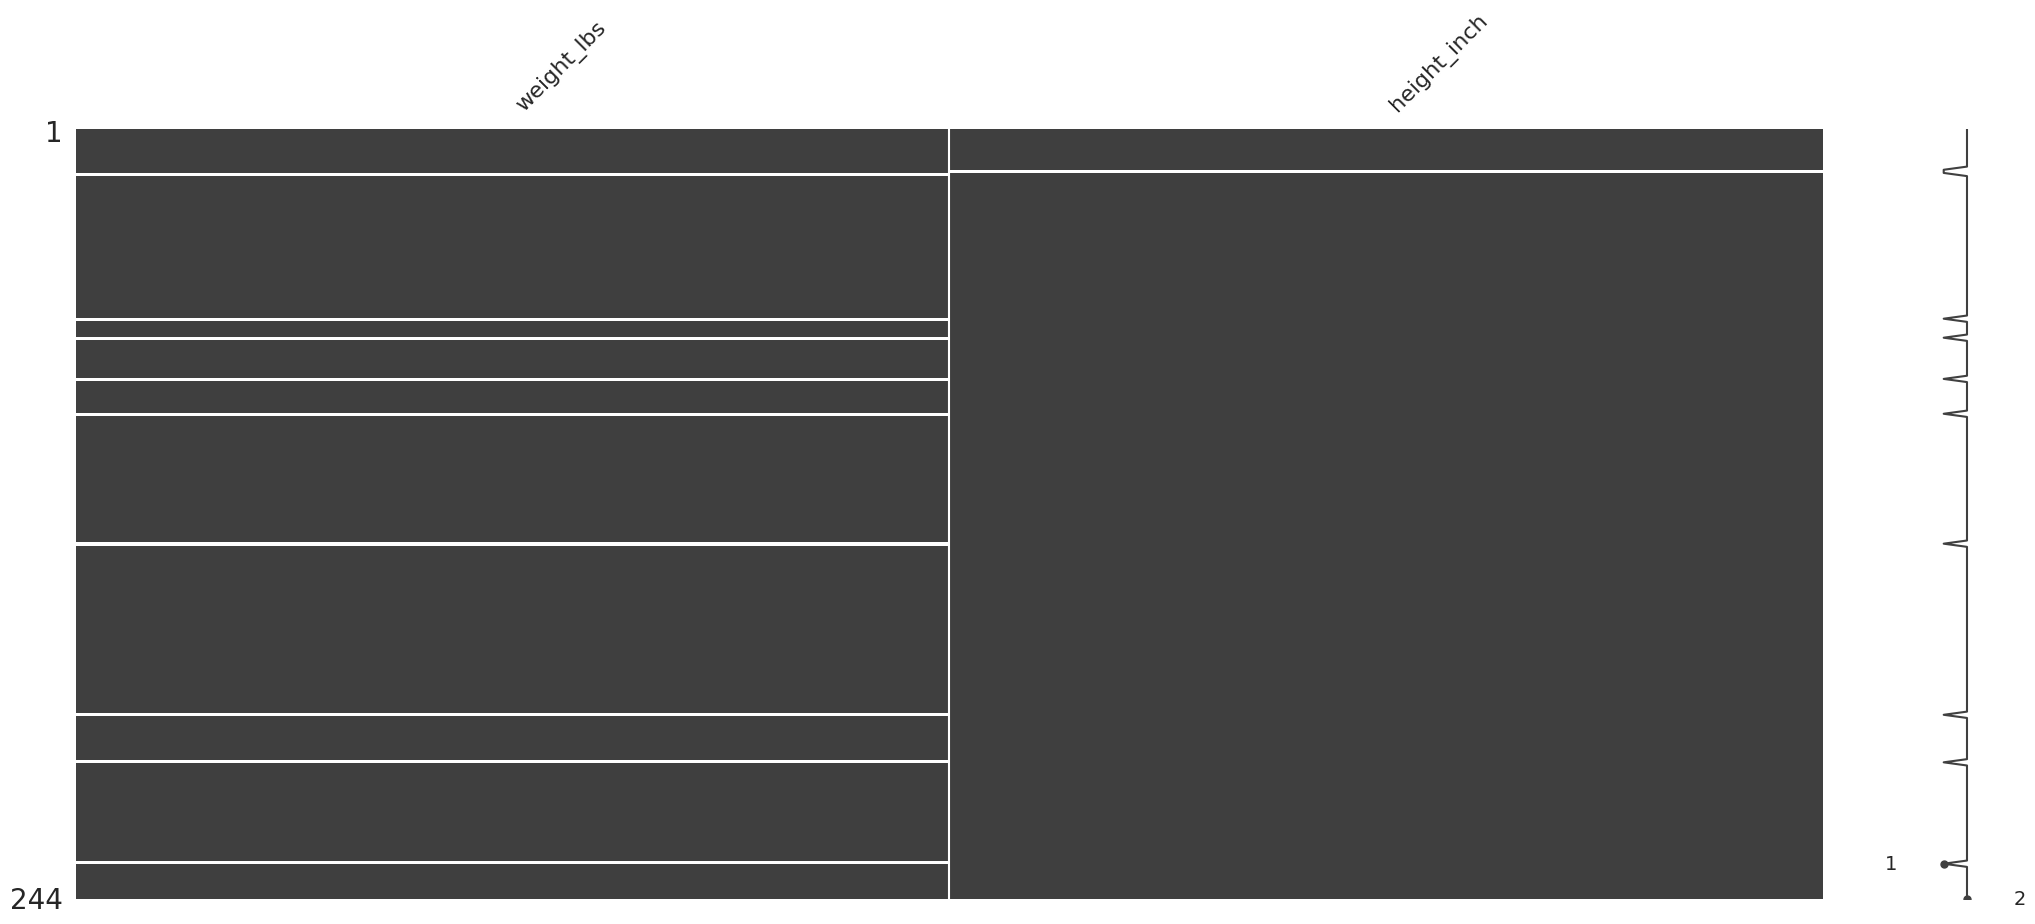

In [89]:
(
    riskfactors_df
    .dropna(
        subset=['weight_lbs','height_inch'],
        how='all'
    )
    .select_columns(['weight_lbs','height_inch'])
    .pipe(missingno.matrix)
)

## Imputación básica de valores faltantes

### Imputación con base en el contexto

In [90]:
implicit_to_explicit_df = pd.DataFrame(
    data={
        "name": ["lynn", np.nan, "zelda", np.nan, "shadowsong", np.nan],
        "time": ["morning", "afternoon", "morning", "afternoon", "morning", "afternoon",],
        "value": [350, 310, 320, 350, 310, 320]
    }
)

implicit_to_explicit_df

,name,time,value
0,lynn,morning,350
1,NaN,afternoon,310
2,zelda,morning,320
3,NaN,afternoon,350
4,shadowsong,morning,310
5,NaN,afternoon,320


In [91]:
implicit_to_explicit_df.ffill()

,name,time,value
0,lynn,morning,350
1,lynn,afternoon,310
2,zelda,morning,320
3,zelda,afternoon,350
4,shadowsong,morning,310
5,shadowsong,afternoon,320


### Imputación de un único valor

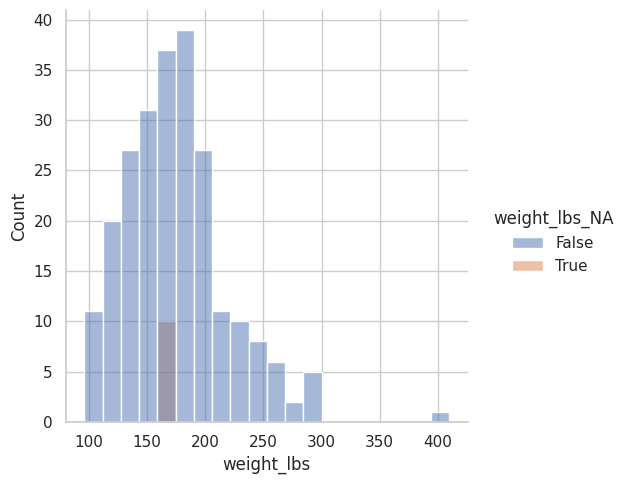

In [97]:
(
    riskfactors_df
    [['weight_lbs', 'height_inch', 'bmi']]  # Corregido para seleccionar columnas
    .missing.bind_shadow_matrix(true_string=True, false_string=False)
    .apply(  # Corregido a 'apply'
        lambda column: column.fillna(column.mean()) if '_NA' not in column.name else column,
        axis=0  # Cambiado a axis=0 para aplicar la función a cada columna
    )
    .pipe(
        lambda df: (
            sns.displot(
                data=df,
                x='weight_lbs',
                hue='weight_lbs_NA'
            )
        )
    )
)


<AxesSubplot:xlabel='weight_lbs', ylabel='height_inch'>

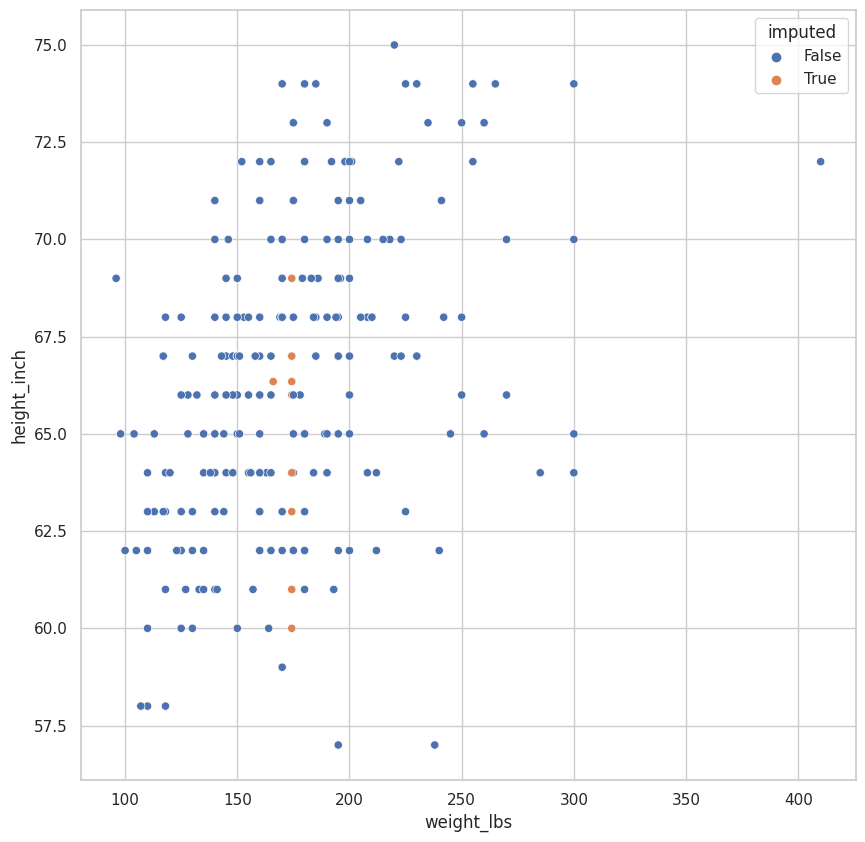

In [102]:
(
    riskfactors_df
    [['weight_lbs', 'height_inch', 'bmi']]  # Corregido para seleccionar columnas
    .missing.bind_shadow_matrix(true_string=True, false_string=False)
    .apply(
        axis = 'rows' ,
        func = lambda column: column.fillna(column.mean()) if '_NA' not in column.name else column
    )
    .assign(
        imputed = lambda df: df.weight_lbs_NA | df.height_inch_NA
    )
    .pipe(
        lambda df: (
            sns.scatterplot(
                data=df,
                x='weight_lbs',
                y='height_inch',
                hue='imputed'
            )
        )
    )
)

In [115]:
(
    riskfactors_df
    [['weight_lbs', 'height_inch', 'bmi']]  # Corregido para seleccionar columnas
    .missing.bind_shadow_matrix(true_string=True, false_string=False)
    .apply(
        axis = 'rows' ,
        func = lambda column: column.fillna(column.mean()) if '_NA' not in column.name else column
    )
    .assign(
        imputed = lambda df: df.weight_lbs_NA | df.height_inch_NA
    )
    .pivot_longer(
        index='*_NA'

    )
    .pivot_longer(
        index=['variable', 'value'],
        names_to='variable_NA',
        values_to='value_NA'

    )
    .assign(
        valid=lambda  df: df.apply(axis='columns', func = lambda column: column.variable in column.variable_NA)
    )
    .query("valid")
    .pipe(
        lambda df: sns.displot(
            data=df,
            x="value",
            hue="value_NA",
            col="variable",
            common_bins=False,
            facet_kws={"sharex": False, "sharey": False}
        )
    )
)

## Continúa aprendiendo sobre el manejo de valores faltantes

<div class="alert alert-success">
    <b style="font-size: 1.5em;">✅ ¡Felicidades por terminar el curso!</b>
    <p>
Has aprendido bastante sobre la exploración y manipulación de valores faltantes.
    </p>
    <p>
Empezaste conociento las principales operaciones al trabajar con valores faltantes. Ahora, eres consciente de que estas operaciones no son universales y cada software decide tratar a los valores faltantes a su conveniencia.
    </p>
    <p>
Y, hablando de conveniencias, comenzaste tu camino en la exploración de valores faltantes a través de una representación universal de qué es lo que faltaba. No obstante, no pasó mucho para darte cuenta de que los valores faltantes pueden existir en formas muy variables. Incluso, en formas en las que no sabemos que nos faltan estos valores en sí mismos. 
    </p>
    <p>
Con los valores faltantes ya expuestos, te conviertes en una persona capaz de explorarlos en profundidad de forma estadística y visual. Entendiendo así, los distintos mecanismos que pueden tener los valores faltantes: MCAR, MAR y MNAR.
    </p>
    <p>
A su vez, aprendiste las bases sobre cómo tratarlos a través de la eliminación de elementos o la imputación de valores de una forma básica y sencilla. Por lo tanto, necesitarás continuar tu camino de aprendizaje con un curso que te permita profundizar en estas técnicas de tratamiento para valores faltantes.
    </p>
    <p>
Te recomiendo continuar con mi <a href="https://platzi.com/cursos/datos-faltantes-imputacion/">Curso de Manejo de Datos Faltantes: Imputación</a>. Estoy seguro de que tus habilidades adquiridas hasta el momento mejorarán, permitiéndote realizar análisis cada vez más complejos y cercanos al mundo real.
    </p>
    <p>
    Con mucha alegría por tu logro,
   Jesús Vélez Santiago
    </p>
    
</div>

## Información de sesión

In [103]:
session_info.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=88617571-4eed-4d7c-be16-1047c6187bb4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>